## Initial setup
This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook present a first stage on a SA and UA. It is a screening process using the Elementary Effects Test (EET). For this, The EMA workbench is used with SAlib Morris sampler.


In [141]:

'''
By Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on 18 December 2019

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

#from ema_workbench.analysis.plotting_util import BOXPLOT, KDE, VIOLIN
from ema_workbench.analysis.plotting import envelopes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from ema_workbench.analysis import prim
#import pareto
import os
import glob
import numpy as np
import pandas as pd
import os
import glob

includePlots = False

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [142]:
from ema_workbench import load_results
#AfterbaseYear resutls: last results Dec 02 2020
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_EET2020ABY-Dec-02.tar.gz')

#Before and after base year results: last results on Jan 14 2021
#results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_EETPast2021-Jan-14.tar.gz')


In [143]:
experiments, outcomes = results
outcomes['PrimarySpot-WholesalePriceYear'] = outcomes['wholesalePriceYear']


# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [144]:
experiments.describe()

annualCpi  annualInflation  domesticConsumptionPercentage  \
count  7000.000000      7000.000000                     7000.00000   
mean      2.664714         2.709286                       38.06400   
std       1.445692         1.463340                       12.66755   
min       1.000000         1.000000                       20.00000   
25%       1.000000         2.000000                       34.00000   
50%       3.000000         2.000000                       41.00000   
75%       3.000000         3.000000                       55.00000   
max       5.000000         5.000000                       55.00000   

       generationRolloutPeriod  generatorRetirement  importPriceFactor  \
count              7000.000000          7000.000000        7000.000000   
mean                  4.950286            -0.032286          -0.351429   
std                   3.748614             3.643977          37.688490   
min                   0.000000            -5.000000         -50.000000   
25%                   0.000000            -5.000000         -50.000000   
50%                   6.000000             1.000000         -10.000000   
75%                  10.000000             5.000000          50.000000   
max                  10.000000             5.000000          50.000000   

       includePublicallyAnnouncedGen  learningCurve  \
count                    7000.000000    7000.000000   
mean                        0.257000       7.248857   
std                         0.437011       5.343287   
min                         0.000000       0.000000   
25%                         0.000000       0.000000   
50%                         0.000000       6.000000   
75%                         1.000000       9.000000   
max                         1.000000      15.000000   

       nameplateCapacityChangeBattery  nameplateCapacityChangeBrownCoal  ...  \
count                     7000.000000                       7000.000000  ...   
mean                         1.340000                         -1.848571  ...   
std                         35.933116                         35.541008  ...   
min                        -50.000000                        -50.000000  ...   
25%                        -10.000000                        -50.000000  ...   
50%                         10.000000                        -10.000000  ...   
75%                         50.000000                         10.000000  ...   
max                         50.000000                         50.000000  ...   

       priceChangePercentageBrownCoal  priceChangePercentageCcgt  \
count                     7000.000000                7000.000000   
mean                         0.617143                  -0.060000   
std                         35.866858                  36.219345   
min                        -50.000000                 -50.000000   
25%                        -10.000000                 -50.000000   
50%                         10.000000                 -10.000000   
75%                         10.000000                  50.000000   
max                         50.000000                  50.000000   

       priceChangePercentageOcgt  priceChangePercentageSolar  \
count                7000.000000                 7000.000000   
mean                   -0.634286                   -0.985714   
std                    35.419200                   35.270470   
min                   -50.000000                  -50.000000   
25%                   -50.000000                  -50.000000   
50%                    10.000000                   10.000000   
75%                    10.000000                   10.000000   
max                    50.000000                   50.000000   

       priceChangePercentageWater  priceChangePercentageWind  \
count                 7000.000000                7000.000000   
mean                    -0.574286                  -0.622857   
std                     36.450789                  35.593240   
min                    -50.000000               

The outcomes are shown in year. Though another analysis can be done for monthly outcomes. 
In total (Jul 2020), there are 30 uncertain inputs (previous version 33 levers). 
Updated version (August 2020) included another input for the analysis. Therefore bringing the number of 31 inputs for the EET. The new input is to represent the changes on percentage of domestic consumption, as it was assumed to be an average of 30% during the whole simulation, but it is currently at 22% so this variability had to be checked. 
The Sep-Oct 2020 version has the same number of uncertainties, however another EET was run given that changes to nominal values and uncertanty ranges were made.

In [145]:
#outcomes Options: wholesalePriceYear, GHGYear, tariffsYear, primarySpotProductionYear,
# secondarySpotProductionYear, offSpotProductionYear, rooftopPvProductionYear
# numActorsYear
outcomes_to_show =  ['consumptionYear', 'tariffsYear', 'wholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'BatteryProductionYear', 'primaryUnmetDemandMwh', 'primaryUnmetDemandHours',
                    'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 'secondaryUnmetDemandMwh',
                    'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays','secondaryMaxUnmetDemandMwhPerHour']
#outcomes_to_show = ['PrimarySpot-WholesalePriceYear']
#outcomes_to_show = ['GHGYear', 'renewableContributionYear', 'wholesalePriceYear', 'tariffsYear']


uncertainties = experiments.columns[:-3]
#levers = ['rooftopPV', 'solarUptake']

#from startYear
startYear = 2019 # afterBaseYear
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
#time = outcomes['TIMEYear'][0, startYearShift:-31]
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

for u in uncertainties:
    var = experiments[u]
    val = np.unique(var)
    print("{}: {}".format(u,val))

annualCpi: [1. 2. 3. 5.]
annualInflation: [1. 2. 3. 5.]
consumption: ['Central' 'Fast change' 'High DER' 'Slow change']
domesticConsumptionPercentage: [20. 34. 41. 55.]
energyEfficiency: ['Central' 'Slow change' 'Step change']
generationRolloutPeriod: [ 0.  4.  6. 10.]
generatorRetirement: [-5. -1.  1.  5.]
importPriceFactor: [-50. -10.  10.  50.]
includePublicallyAnnouncedGen: [0. 1.]
learningCurve: [ 0.  6.  9. 15.]
nameplateCapacityChangeBattery: [-50. -10.  10.  50.]
nameplateCapacityChangeBrownCoal: [-50. -10.  10.  50.]
nameplateCapacityChangeCcgt: [-50. -10.  10.  50.]
nameplateCapacityChangeOcgt: [-50. -10.  10.  50.]
nameplateCapacityChangeSolar: [-50. -10.  10.  50.]
nameplateCapacityChangeWater: [-50. -10.  10.  50.]
nameplateCapacityChangeWind: [-50. -10.  10.  50.]
nonScheduleGenSpotMarket: ['none' 'primary' 'secondary']
nonScheduleMinCapMarketGen: [ 0.1   6.06  9.04 15.  ]
onsiteGeneration: ['Central' 'Slow change' 'Step change']
priceChangePercentageBattery: [-50. -10.  

## EET
To obtain the SALib results for each input

In [146]:
from gr4spModelEET import getModel
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModel()
UncertaintiesCategories = determine_parameters(model, 'uncertainties', union=False) 
problem = get_SALib_problem(UncertaintiesCategories)

# Build input values as floats used for each lever/uncertainty to generate outcomes. Recover them from experiments variable
X = None
for u in uncertainties:
    col_cat = None
    # map category to an index
    if isinstance(model.uncertainties[u], CategoricalParameter):
        col_cat = [ float(model.uncertainties[u].index_for_cat(cat)) for cat in experiments[u] ]
    else:
        col_cat = [ float(cat) for cat in experiments[u] ]
    
    # Concatenate each lever/uncertainty
    if X is None:
        X=col_cat
    else:
        X = np.column_stack((X,col_cat))



## Analysis of EET
The analyse method from SALib helps in the identification of the key sensitivity measures: mu, mu*, and sigma

In [147]:
from SALib.analyze import morris

sigma_years_ooi = {}
mu_star_years_ooi = {}
for ooi in outcomes_to_show:
    mu_star_years = pd.DataFrame([],columns=uncertainties)
    sigma_years = pd.DataFrame([],columns=uncertainties)
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_levels = p to do the analysis with p levels
        Si = morris.analyze(problem, X, dataY, num_levels=6)
        
        morris_stats = {key: Si[key] for key in ['mu', 'mu_star', 'sigma',
                                                           'mu_star_conf']}
        morris_stats = pd.DataFrame(morris_stats, index=uncertainties)
        
        mu_star = pd.DataFrame([morris_stats['mu_star']],columns=uncertainties)                    
        mu_star_years = mu_star_years.append(mu_star)
        
        sigma = pd.DataFrame([Si['sigma']], columns=uncertainties)
        sigma_years = sigma_years.append(sigma)
    
    mu_star_years = mu_star_years.set_index(time)
    sigma_years = sigma_years.set_index(time)
    
    #Filter columns for which all values are zero
    mu_star_years = mu_star_years[mu_star_years.columns[(mu_star_years != 0).any()]]
    sigma_years = sigma_years[sigma_years.columns[(sigma_years != 0).any()]]
    
    mu_star_years_ooi[ooi] = mu_star_years_ooi
    sigma_years_ooi[ooi] = sigma_years
    print(ooi)
    if includePlots:
        # Figure showing timeseries of mu* and sigma for each output and lever/uncertainty
        if mu_star_years.empty is False:
            plt_mu_star_years = mu_star_years.plot.line(title=ooi+' - mu_star', figsize=(30, 20), fontsize=20)
            plt_mu_star_years.set_title(f"{ooi} - mu_star", fontsize=25)
            plt.legend(fontsize=20)
            plt_mu_star_years.get_figure().savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_mu_star_years_%s'%(ooi)), 
                             dpi=300, bbox_inches='tight')
        
        if sigma_years.empty is False:
            plt_sigma_years = sigma_years.plot.line(title=ooi + ' - sigma', figsize=(30, 20), fontsize=20)
            plt_sigma_years.set_title(f"{ooi} - sigma", fontsize=25)
            plt.legend(fontsize=20)
            plt_sigma_years.get_figure().savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sigma_years_%s'%(ooi)), 
                             dpi=300, bbox_inches='tight')    

consumptionYear
tariffsYear
wholesalePriceYear
GHGYear
primarySpotProductionYear
secondarySpotProductionYear
offSpotProductionYear
renewableContributionYear
rooftopPVProductionYear
coalProductionYear
waterProductionYear
windProductionYear
gasProductionYear
solarProductionYear
BatteryProductionYear
primaryUnmetDemandMwh
primaryUnmetDemandHours
primaryUnmetDemandDays
primaryMaxUnmetDemandMwhPerHour
secondaryUnmetDemandMwh
secondaryUnmetDemandHours
secondaryUnmetDemandDays
secondaryMaxUnmetDemandMwhPerHour


In [286]:
normalized_mu_star_years = {}
for ooi in outcomes_to_show:
    normalized_mu_star_years[ooi] = (mu_star_years_ooi[ooi] - mu_star_years_ooi[ooi].min().min())/(mu_star_years_ooi[ooi].max().max() - mu_star_years_ooi[ooi].min().min())
    #normalized_sigma_years[ooi] = (sigma_years_ooi[ooi] - sigma_max_val_ooia_years_ooi[ooi].min())/sigma_max_val_ooi[ooi].max() - sigma_max_val_ooi[ooi].min())


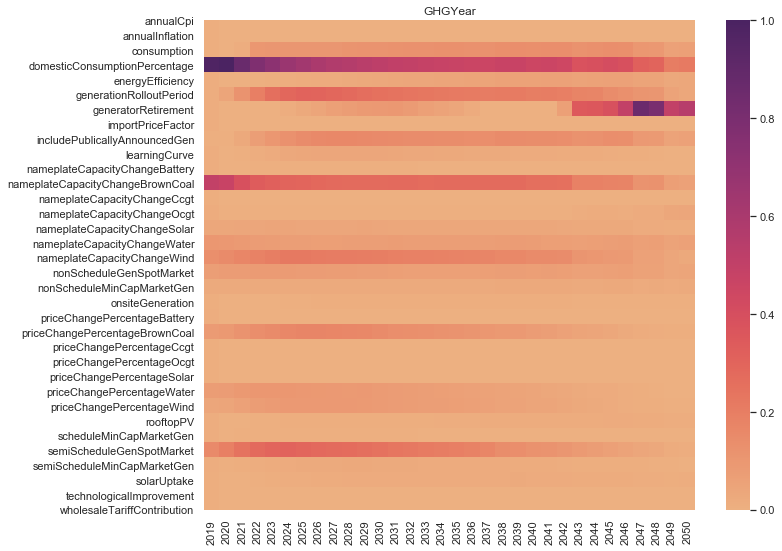

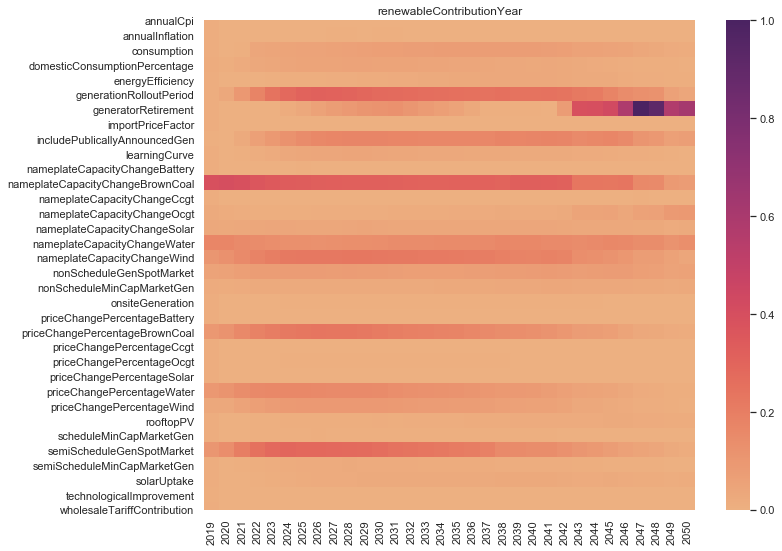

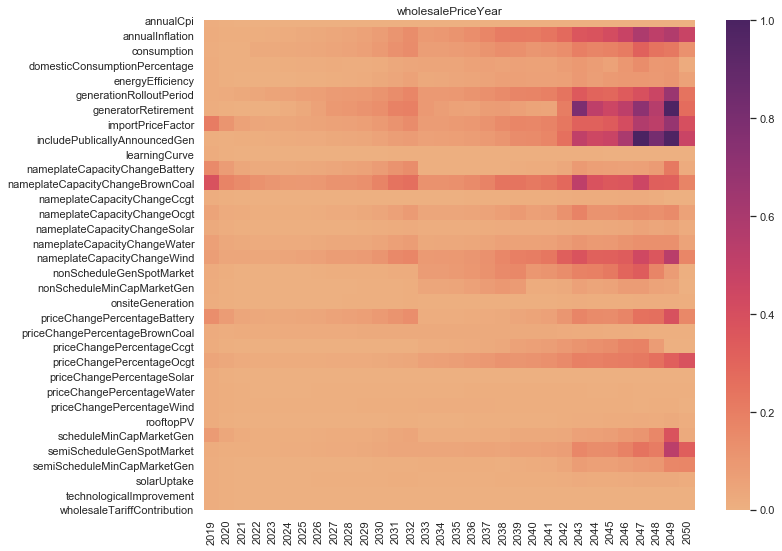

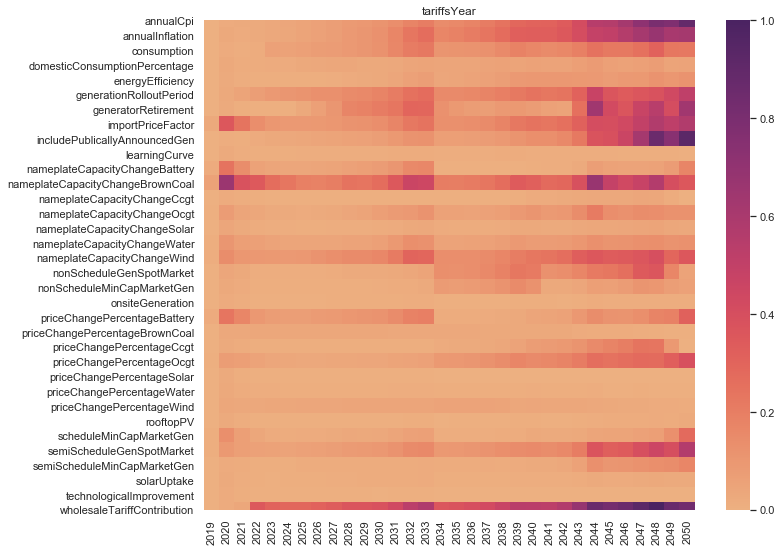

In [287]:
for ooi in outcomes_to_show:
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.color_palette("flare", as_cmap=True)
    

    im = sns.heatmap(normalized_mu_star_years[ooi].T, cmap = cmap)
    ax.set_title(ooi)
    plt.show()

### Mu * per year

In [148]:

#Save mu_star into EXCEL
writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_mu_star'), engine='xlsxwriter')
for ooi in outcomes_to_show:
    
    mu_star_years = mu_star_years_ooi[ooi]
    if ooi == 'secondaryMaxUnmetDemandMwhPerHour':
        ooi = 'secondMaxUnmetMwhPerHour'
    mu_star_years.to_excel(writer, sheet_name=ooi)
writer.save()

#Save sigma into EXCEL
writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_sigma'), engine='xlsxwriter')
for ooi in outcomes_to_show:
    sigma_years = sigma_years_ooi[ooi]
    if ooi == 'secondaryMaxUnmetDemandMwhPerHour':
        ooi = 'secondMaxUnmetMwhPerHour'
    sigma_years.to_excel(writer, sheet_name=ooi)
writer.save()

### Average mu_star and sigma all years in data frame

In [149]:
mu_star_average_ooi = {}
mu_star_max_val_ooi = {}
mu_star_median_ooi = {}
sigma_average_ooi = {}
sigma_max_val_ooi = {}
sigma_median_ooi = {}

for ooi in outcomes_to_show:
    
    mu_star_average_ooi[ooi] = mu_star_years_ooi[ooi].mean()    
    mu_star_max_val_ooi[ooi] = mu_star_years_ooi[ooi].max()
    mu_star_median_ooi[ooi] = mu_star_years_ooi[ooi].median()
    sigma_average_ooi[ooi] = sigma_years_ooi[ooi].mean()
    sigma_max_val_ooi[ooi] = sigma_years_ooi[ooi].max()
    sigma_median_ooi[ooi] = sigma_years_ooi[ooi].median()

### Scatter plots of mu_star vs sigma using max values
Previous figures shown the changes of mu* and sigma over time for each lever/uncertainty and output. However, it is difficult to capture the most significant inputs, for this a mu* vs sigma plot (EET) is more
appropriate.  

In [150]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 
if includePlots:
    for ooi in outcomes_to_show:

        #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
        normalized_mu_star = (mu_star_max_val_ooi[ooi] - mu_star_max_val_ooi[ooi].min())/(mu_star_max_val_ooi[ooi].max() - mu_star_max_val_ooi[ooi].min())
        normalized_sigma = (sigma_max_val_ooi[ooi] - sigma_max_val_ooi[ooi].min())/(sigma_max_val_ooi[ooi].max() - sigma_max_val_ooi[ooi].min())

        df_max = pd.concat({'mu_star_max': normalized_mu_star,'sigma_max': normalized_sigma}, axis=1)

        f=plt.figure(figsize=(20,15))
        f.suptitle(ooi)
        


        sns.scatterplot(x='mu_star_max',y='sigma_max', hue=df_max.index, data=df_max)

        #df_max.plot.scatter(x='mu_star_max',y='sigma_max',c='DarkBlue')

        #Add labels above points
        for index, row in df_max.iterrows():
                if row['mu_star_max'] <= 0.1 and row['sigma_max'] <= 0.1: continue
                plt.annotate(index, # this is the text
                             (row['mu_star_max'],row['sigma_max']), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(0,3), # distance from text to points (x,y)
                             ha='left', # horizontal alignment can be left, right or center
                             fontsize=12)  # font size


        break
        print(ooi)

        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', 'scatter_mu_star_sigmna_max_%s'%(ooi)),dpi=300, bbox_inches='tight')
    
# f.show()
# f.clear()
# plt.close(f)

### Subset significant factors - normalisation max values
Scatter plots of mu_star vs sigma 

In [151]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 

#bound used to filter INPUTS
significance_bound = 0.3
significant_inputs_max = set()
significant_inputs_filter_max = {}
for ooi in outcomes_to_show:
    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_max_val_ooi[ooi] - mu_star_max_val_ooi[ooi].min())/(mu_star_max_val_ooi[ooi].max() - mu_star_max_val_ooi[ooi].min())
    normalized_sigma = (sigma_max_val_ooi[ooi] - sigma_max_val_ooi[ooi].min())/(sigma_max_val_ooi[ooi].max() - sigma_max_val_ooi[ooi].min())
    
    #filter values
    filter_mu_star = normalized_mu_star > significance_bound
    filter_sigma = normalized_sigma > significance_bound
    normalized_mu_star_filtered = normalized_mu_star[ filter_mu_star | filter_sigma ]
    normalized_sigma_filtered = normalized_sigma[ filter_mu_star | filter_sigma ] 
    
    #keep track significant inputs filter
    significant_inputs_filter_max[ooi] = normalized_mu_star_filtered.index.values
    for l in normalized_mu_star_filtered.index.values:
        significant_inputs_max.add(l) 
    
    #create dataframe     
    df_max = pd.concat({'mu_star_max': normalized_mu_star_filtered,'sigma_max': normalized_sigma_filtered}, axis=1)
    
    #print significant indexes per ooi
    print(ooi + ' - {}'.format(len(significant_inputs_filter_max[ooi])))
    print(significant_inputs_filter_max[ooi])
    
    if includePlots:
        #create figure
        f=plt.figure()#figsize=(30,20))
        f.suptitle(ooi, fontsize=20)

        #ScatterPlot        
        sns.scatterplot(x='mu_star_max',y='sigma_max', hue=df_max.index, data=df_max, legend=False)


        #Add labels above points
        for index, row in df_max.iterrows():
                plt.annotate(index, # this is the text
                             (row['mu_star_max'],row['sigma_max']), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(2,-2), # distance from text to points (x,y)
                             ha='center', # horizontal alignment can be left, right or center
                             fontsize=6)  # font size

        

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs','scatter_mu_star_sigmna_max_%s_filtered'%(ooi)),dpi=300, bbox_inches='tight')


print("ALL significant inputs (%d)"%len(significant_inputs_max))
print(significant_inputs_max)

consumptionYear - 3
['consumption' 'domesticConsumptionPercentage' 'energyEfficiency']
tariffsYear - 17
['annualCpi' 'annualInflation' 'consumption' 'generationRolloutPeriod'
 'generatorRetirement' 'importPriceFactor' 'includePublicallyAnnouncedGen'
 'nameplateCapacityChangeBattery' 'nameplateCapacityChangeBrownCoal'
 'nameplateCapacityChangeWind' 'nonScheduleGenSpotMarket'
 'priceChangePercentageBattery' 'priceChangePercentageOcgt'
 'scheduleMinCapMarketGen' 'semiScheduleGenSpotMarket'
 'semiScheduleMinCapMarketGen' 'wholesaleTariffContribution']
wholesalePriceYear - 15
['annualInflation' 'consumption' 'generationRolloutPeriod'
 'generatorRetirement' 'importPriceFactor' 'includePublicallyAnnouncedGen'
 'nameplateCapacityChangeBattery' 'nameplateCapacityChangeBrownCoal'
 'nameplateCapacityChangeWind' 'nonScheduleGenSpotMarket'
 'priceChangePercentageBattery' 'priceChangePercentageOcgt'
 'scheduleMinCapMarketGen' 'semiScheduleGenSpotMarket'
 'semiScheduleMinCapMarketGen']
GHGYear - 9
['

<Figure size 432x288 with 0 Axes>

In [152]:
normalized_mu_star.index

Index(['annualCpi', 'annualInflation', 'consumption',
       'domesticConsumptionPercentage', 'energyEfficiency',
       'generationRolloutPeriod', 'generatorRetirement', 'importPriceFactor',
       'includePublicallyAnnouncedGen', 'learningCurve',
       'nameplateCapacityChangeBattery', 'nameplateCapacityChangeBrownCoal',
       'nameplateCapacityChangeCcgt', 'nameplateCapacityChangeOcgt',
       'nameplateCapacityChangeSolar', 'nameplateCapacityChangeWater',
       'nameplateCapacityChangeWind', 'nonScheduleGenSpotMarket',
       'nonScheduleMinCapMarketGen', 'onsiteGeneration',
       'priceChangePercentageBattery', 'priceChangePercentageBrownCoal',
       'priceChangePercentageCcgt', 'priceChangePercentageOcgt',
       'priceChangePercentageSolar', 'priceChangePercentageWater',
       'priceChangePercentageWind', 'rooftopPV', 'scheduleMinCapMarketGen',
       'semiScheduleGenSpotMarket', 'semiScheduleMinCapMarketGen',
       'solarUptake', 'technologicalImprovement',
       'whole

### Scatter plots of mu_star vs sigma using mean values

In [153]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 
if includePlots:
    for ooi in outcomes_to_show:

        #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
        normalized_mu_star = ( mu_star_median_ooi[ooi] -  mu_star_median_ooi[ooi].min())/( mu_star_median_ooi[ooi].max() -  mu_star_median_ooi[ooi].min())
        normalized_sigma = (sigma_median_ooi[ooi] - sigma_median_ooi[ooi].min())/(sigma_median_ooi[ooi].max() - sigma_median_ooi[ooi].min())

        df_max = pd.concat({'mu_star_median': normalized_mu_star,'sigma_median': normalized_sigma}, axis=1)

        f=plt.figure(figsize=(20,15))
        f.suptitle(ooi, fontsize=20)

        sns.scatterplot(x='mu_star_median',y='sigma_median', hue=df_max.index, data=df_max)
        #df_max.plot.scatter(x='mu_star_max',y='sigma_max',c='DarkBlue')

        #Add labels above points
        for index, row in df_max.iterrows():
                if row['mu_star_median'] <= 0.1 and row['sigma_median'] <= 0.1: continue
                plt.annotate(index, # this is the text
                             (row['mu_star_median'],row['sigma_median']), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(0,3), # distance from text to points (x,y)
                             ha='left', # horizontal alignment can be left, right or center
                             fontsize=10)  # font size


        
        print(ooi)

        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', 'scatter_mu_star_sigmna_median_%s'%(ooi)),dpi=300, bbox_inches='tight')

# f.show()
# f.clear()
# plt.close(f)

### Subset significant factors - normalisation median values
Scatter plots of mu_star vs sigma 

In [170]:
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
#f = plt.figure(figsize=(20,30)) 
#bound used to filter INPUTS
significance_bound = 0.2
significant_inputs_median = set()
significant_inputs_filter_median = {}
normalized_mu_star_median_ooi = {}
normalized_sigma_median_ooi = {}

for ooi in outcomes_to_show:
    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_median_ooi[ooi] - mu_star_median_ooi[ooi].min())/(mu_star_median_ooi[ooi].max() - mu_star_median_ooi[ooi].min())
    normalized_sigma = (sigma_median_ooi[ooi] - sigma_median_ooi[ooi].min())/(sigma_median_ooi[ooi].max() - sigma_median_ooi[ooi].min())
    normalized_mu_star_median_ooi[ooi] = normalized_mu_star
    normalized_sigma_median_ooi[ooi] = normalized_sigma

    
    #filter values
    filter_mu_star = normalized_mu_star > significance_bound
    filter_sigma = normalized_sigma > significance_bound
    normalized_mu_star_filtered = normalized_mu_star[ filter_mu_star | filter_sigma ]
    normalized_sigma_filtered = normalized_sigma[ filter_mu_star | filter_sigma ] 
    
    #keep track significant inputs filter
    significant_inputs_filter_median[ooi] = normalized_mu_star_filtered.index.values
    for l in normalized_mu_star_filtered.index.values:
        significant_inputs_median.add(l) 
    
    #create dataframe     
    df_med = pd.concat({'mu_star_median': normalized_mu_star_filtered,'sigma_median': normalized_sigma_filtered}, axis=1)
    df_med['Input Factors'] = np.arange(len(df_med))+1

    
    #print significant indexes per ooi
    print(ooi + ' - {}'.format(len(significant_inputs_filter_median[ooi])))
    print(significant_inputs_filter_median[ooi])

#     if includePlots:
#         #create figure
#         f=plt.figure(figsize=(10,10))
#         f.suptitle(ooi)
        
#         ax = sns.scatterplot(x='mu_star_median',y='sigma_median', hue=df_med.index, data=df_med, legend=True)

#         # replace labels
#         for t in ax.legend_.texts: 
#             t.set_text('$x_{%d}$ - %s'%(df_med.loc[t.get_text(),'Input Factors'],t.get_text()))
#         plt.setp(ax.get_legend().get_texts(), fontsize='12') # for legend text

#         #replace axes names
#         ax.set_xlabel('$\\tilde{M}_{Norm}$', fontsize=16)
#         ax.set_ylabel('$\\tilde{S}_{Norm}$', fontsize=16)

        
#         #Add labels above points
#         for index, row in df_med.iterrows():
#                 plt.annotate('$x_{%d}$'%df_med.loc[index,'Input Factors'], # this is the text
#                              (row['mu_star_median'],row['sigma_median']), # this is the point to label
#                              textcoords="offset points", # how to position the text
#                              xytext=(1,5), # distance from text to points (x,y)
#                              ha='center', # horizontal alignment can be left, right or center
#                              fontsize=14)  # font size
#     plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs','scatter_mu_star_sigma_median_%s_filtered'%(ooi)),dpi=300, bbox_inches='tight')
    

print("ALL significant inputs (%d)"%len(significant_inputs_median))
print(significant_inputs_median)

consumptionYear - 3
['consumption' 'domesticConsumptionPercentage' 'energyEfficiency']
tariffsYear - 21
['annualCpi' 'annualInflation' 'consumption'
 'domesticConsumptionPercentage' 'energyEfficiency'
 'generationRolloutPeriod' 'generatorRetirement' 'importPriceFactor'
 'includePublicallyAnnouncedGen' 'nameplateCapacityChangeBattery'
 'nameplateCapacityChangeBrownCoal' 'nameplateCapacityChangeOcgt'
 'nameplateCapacityChangeWater' 'nameplateCapacityChangeWind'
 'nonScheduleGenSpotMarket' 'nonScheduleMinCapMarketGen'
 'priceChangePercentageBattery' 'priceChangePercentageOcgt'
 'scheduleMinCapMarketGen' 'semiScheduleGenSpotMarket'
 'wholesaleTariffContribution']
wholesalePriceYear - 18
['annualInflation' 'consumption' 'domesticConsumptionPercentage'
 'energyEfficiency' 'generationRolloutPeriod' 'generatorRetirement'
 'importPriceFactor' 'includePublicallyAnnouncedGen'
 'nameplateCapacityChangeBattery' 'nameplateCapacityChangeBrownCoal'
 'nameplateCapacityChangeOcgt' 'nameplateCapacityChan

Union of significant factors using max and median values across years

In [171]:
significant_inputs = significant_inputs_max.union(significant_inputs_median)
print("ALL significant inputs Union Max and Median analysis (%d)"%len(significant_inputs))
print(significant_inputs)

significant_inputs = significant_inputs_max
print("ALL significant inputs Max analysis (%d)"%len(significant_inputs))
print(significant_inputs)

significant_inputs = significant_inputs_median
print("ALL significant inputs Median analysis (%d)"%len(significant_inputs))
print(significant_inputs)


ALL significant inputs Union Max and Median analysis (29)
{'nonScheduleMinCapMarketGen', 'importPriceFactor', 'domesticConsumptionPercentage', 'learningCurve', 'nameplateCapacityChangeBattery', 'rooftopPV', 'nameplateCapacityChangeOcgt', 'generatorRetirement', 'energyEfficiency', 'nameplateCapacityChangeWind', 'priceChangePercentageBrownCoal', 'nonScheduleGenSpotMarket', 'nameplateCapacityChangeSolar', 'includePublicallyAnnouncedGen', 'priceChangePercentageWater', 'nameplateCapacityChangeWater', 'annualCpi', 'priceChangePercentageOcgt', 'priceChangePercentageWind', 'wholesaleTariffContribution', 'semiScheduleGenSpotMarket', 'annualInflation', 'scheduleMinCapMarketGen', 'generationRolloutPeriod', 'priceChangePercentageBattery', 'semiScheduleMinCapMarketGen', 'nameplateCapacityChangeBrownCoal', 'solarUptake', 'consumption'}
ALL significant inputs Max analysis (28)
{'nonScheduleMinCapMarketGen', 'importPriceFactor', 'domesticConsumptionPercentage', 'nameplateCapacityChangeBattery', 'rooft

In [172]:
#save significant factors (max and median) into EXCEL
writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_significant_max'), engine='xlsxwriter')
significant_inputs_max_df = pd.DataFrame.from_dict(significant_inputs_filter_max,orient='index')
significant_inputs_max_df.to_excel(writer, sheet_name='mu_sigma_max')
writer.save()

writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_significant_median'), engine='xlsxwriter')
significant_inputs_filter_median_df = pd.DataFrame.from_dict(significant_inputs_filter_median,orient='index')
significant_inputs_filter_median_df.to_excel(writer, sheet_name='mu_sigma_median')
writer.save()


In [173]:
#save mu_star median values into excel
writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', 'mu_star_median'), engine='xlsxwriter')
significant_inputs_filter_median_df = pd.DataFrame.from_dict(normalized_mu_star_median_ooi,orient='columns')
significant_inputs_filter_median_df.to_excel(writer, sheet_name='mu_star_median')
writer.save()

writer = pd.ExcelWriter('{}/EE_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', 'sigma_median'), engine='xlsxwriter')
significant_inputs_filter_median_df = pd.DataFrame.from_dict(normalized_sigma_median_ooi,orient='columns')
significant_inputs_filter_median_df.to_excel(writer, sheet_name='sigma_median')
writer.save()

#### The biig 4

GHGYear - 14
['consumption' 'domesticConsumptionPercentage' 'generationRolloutPeriod'
 'generatorRetirement' 'includePublicallyAnnouncedGen' 'learningCurve'
 'nameplateCapacityChangeBrownCoal' 'nameplateCapacityChangeWater'
 'nameplateCapacityChangeWind' 'nonScheduleGenSpotMarket'
 'priceChangePercentageBrownCoal' 'priceChangePercentageWater'
 'priceChangePercentageWind' 'semiScheduleGenSpotMarket']
0 0
renewableContributionYear - 14
['consumption' 'domesticConsumptionPercentage' 'generationRolloutPeriod'
 'generatorRetirement' 'includePublicallyAnnouncedGen' 'learningCurve'
 'nameplateCapacityChangeBrownCoal' 'nameplateCapacityChangeWater'
 'nameplateCapacityChangeWind' 'nonScheduleGenSpotMarket'
 'priceChangePercentageBrownCoal' 'priceChangePercentageWater'
 'priceChangePercentageWind' 'semiScheduleGenSpotMarket']
0 1
wholesalePriceYear - 18
['annualInflation' 'consumption' 'domesticConsumptionPercentage'
 'energyEfficiency' 'generationRolloutPeriod' 'generatorRetirement'
 'importPri

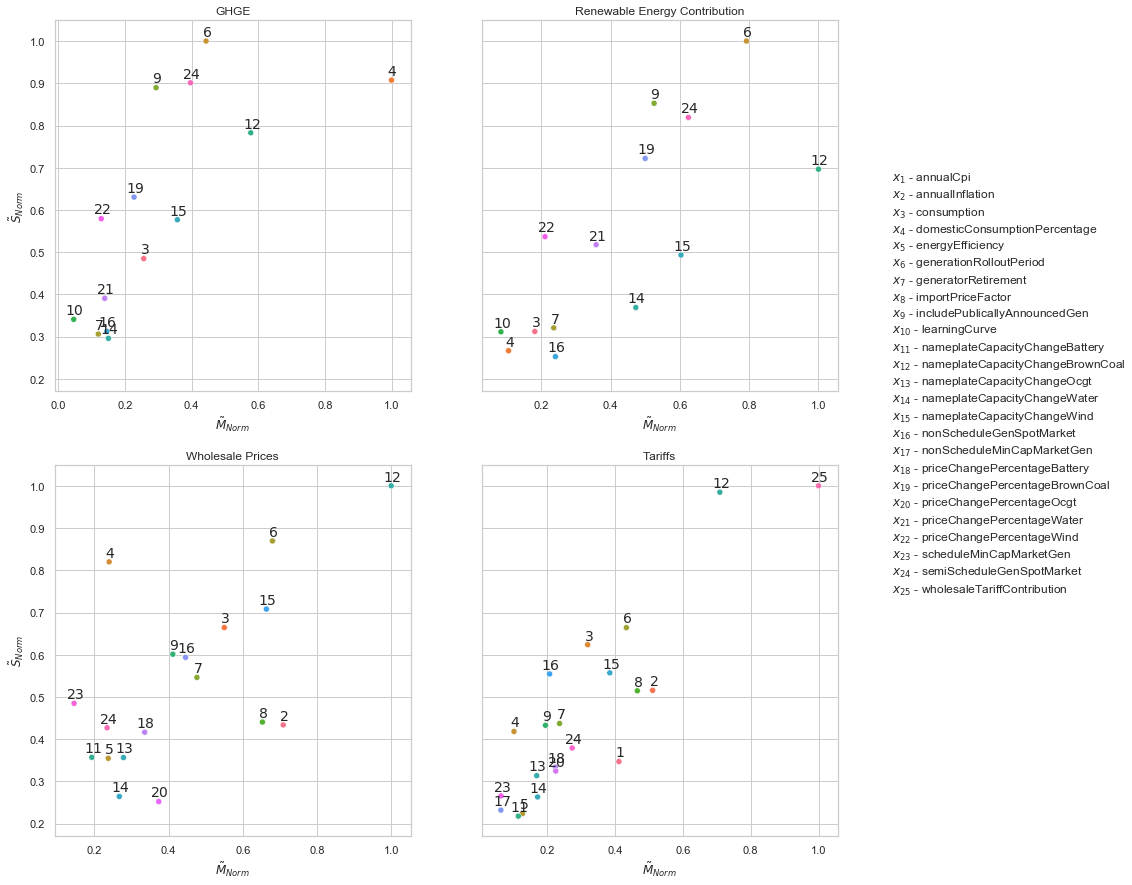

In [232]:
import seaborn as sns; sns.set()
sns.set_style("whitegrid")
#f = plt.figure(figsize=(20,30)) 
includePlots = 1
#bound used to filter INPUTS
significance_bound = 0.2
significant_inputs_median = set()
significant_inputs_filter_median = {}
normalized_mu_star_median_ooi = {}
normalized_sigma_median_ooi = {}


#create multi-figure
fig, axes = plt.subplots(2, 2, figsize=(15, 15),sharey=True)
#fig.suptitle('Mu Star - Median')

# OOI
outcomes_to_show_4 = ['GHGYear', 'renewableContributionYear', 'wholesalePriceYear', 'tariffsYear']

titles_ooi = {'GHGYear': 'GHGE', 'renewableContributionYear':'Renewable Energy Contribution', 
              'wholesalePriceYear': 'Wholesale Prices', 'tariffsYear':'Tariffs'  }

#Gather items that will go into the legend

for ooi in outcomes_to_show_4:
    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_median_ooi[ooi] - mu_star_median_ooi[ooi].min())/(mu_star_median_ooi[ooi].max() - mu_star_median_ooi[ooi].min())
    normalized_sigma = (sigma_median_ooi[ooi] - sigma_median_ooi[ooi].min())/(sigma_median_ooi[ooi].max() - sigma_median_ooi[ooi].min())
    normalized_mu_star_median_ooi[ooi] = normalized_mu_star
    normalized_sigma_median_ooi[ooi] = normalized_sigma

    
    #filter values
    filter_mu_star = normalized_mu_star > significance_bound
    filter_sigma = normalized_sigma > significance_bound
    normalized_mu_star_filtered = normalized_mu_star[ filter_mu_star | filter_sigma ]
    normalized_sigma_filtered = normalized_sigma[ filter_mu_star | filter_sigma ] 
    
    #keep track significant inputs filter
    significant_inputs_filter_median[ooi] = normalized_mu_star_filtered.index.values
    for l in normalized_mu_star_filtered.index.values:
        significant_inputs_median.add(l) 
        

df_legend = pd.DataFrame.from_dict(significant_inputs_median)
df_legend.columns = ['label']
df_legend = df_legend.sort_values(by='label')
df_legend['idx'] = np.arange(len(significant_inputs_median))+1
        
# Create Plots    
for idx, ooi in enumerate(outcomes_to_show_4):

    i = int(idx / 2)
    j = int(idx % 2)

    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_median_ooi[ooi] - mu_star_median_ooi[ooi].min())/(mu_star_median_ooi[ooi].max() - mu_star_median_ooi[ooi].min())
    normalized_sigma = (sigma_median_ooi[ooi] - sigma_median_ooi[ooi].min())/(sigma_median_ooi[ooi].max() - sigma_median_ooi[ooi].min())
    normalized_mu_star_median_ooi[ooi] = normalized_mu_star
    normalized_sigma_median_ooi[ooi] = normalized_sigma

    
    #filter values
    filter_mu_star = normalized_mu_star > significance_bound
    filter_sigma = normalized_sigma > significance_bound
    normalized_mu_star_filtered = normalized_mu_star[ filter_mu_star | filter_sigma ]
    normalized_sigma_filtered = normalized_sigma[ filter_mu_star | filter_sigma ] 
    
    #create dataframe     
    df_med = pd.concat({'mu_star_median': normalized_mu_star_filtered,'sigma_median': normalized_sigma_filtered}, axis=1)
    df_med['Input Factors'] = np.arange(len(df_med))+1

    
    #print significant indexes per ooi
    print(ooi + ' - {}'.format(len(significant_inputs_filter_median[ooi])))
    print(significant_inputs_filter_median[ooi])

    if includePlots:
        
        print(i,j)
        eet_plot = sns.scatterplot(x='mu_star_median',y='sigma_median', hue=df_med.index, data=df_med, 
                                   ax=axes[i,j], legend=False)
        
        axes[i,j].set_title(titles_ooi[ooi])
        
        eet_plot.set(xlabel='$\\tilde{M}_{Norm}$', ylabel='$\\tilde{S}_{Norm}$')
        
        #Add labels above points
        for index, row in df_med.iterrows():
                eet_plot.annotate('${%d}$'%df_legend.loc[df_legend['label']==index,'idx'].values, # this is the text
                             (row['mu_star_median'],row['sigma_median']), # this is the point to label
                             textcoords="offset points", # how to position the text
                             xytext=(1,5), # distance from text to points (x,y)
                             ha='center', # horizontal alignment can be left, right or center
                             fontsize=14)  # font size
    
if includePlots:
    x_legend = '\n'.join('$x_{%d}$ - %s'%(n,name) for n,name in zip(df_legend['idx'].values,df_legend['label'].values))

    t = axes[0,0].text(.9,.35,x_legend,transform=axes[0,0].figure.transFigure)
    fig.subplots_adjust(right=.85)
    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs','scatter_mu_star_sigma_median_%s_filtered'%(ooi)),dpi=300, bbox_inches='tight')
    

print("ALL significant inputs (%d)"%len(significant_inputs_median))
print(significant_inputs_median)

## Histogram normalizsed $\mu^*$ medians

C:\Users\angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

C:\Users\angel\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.m

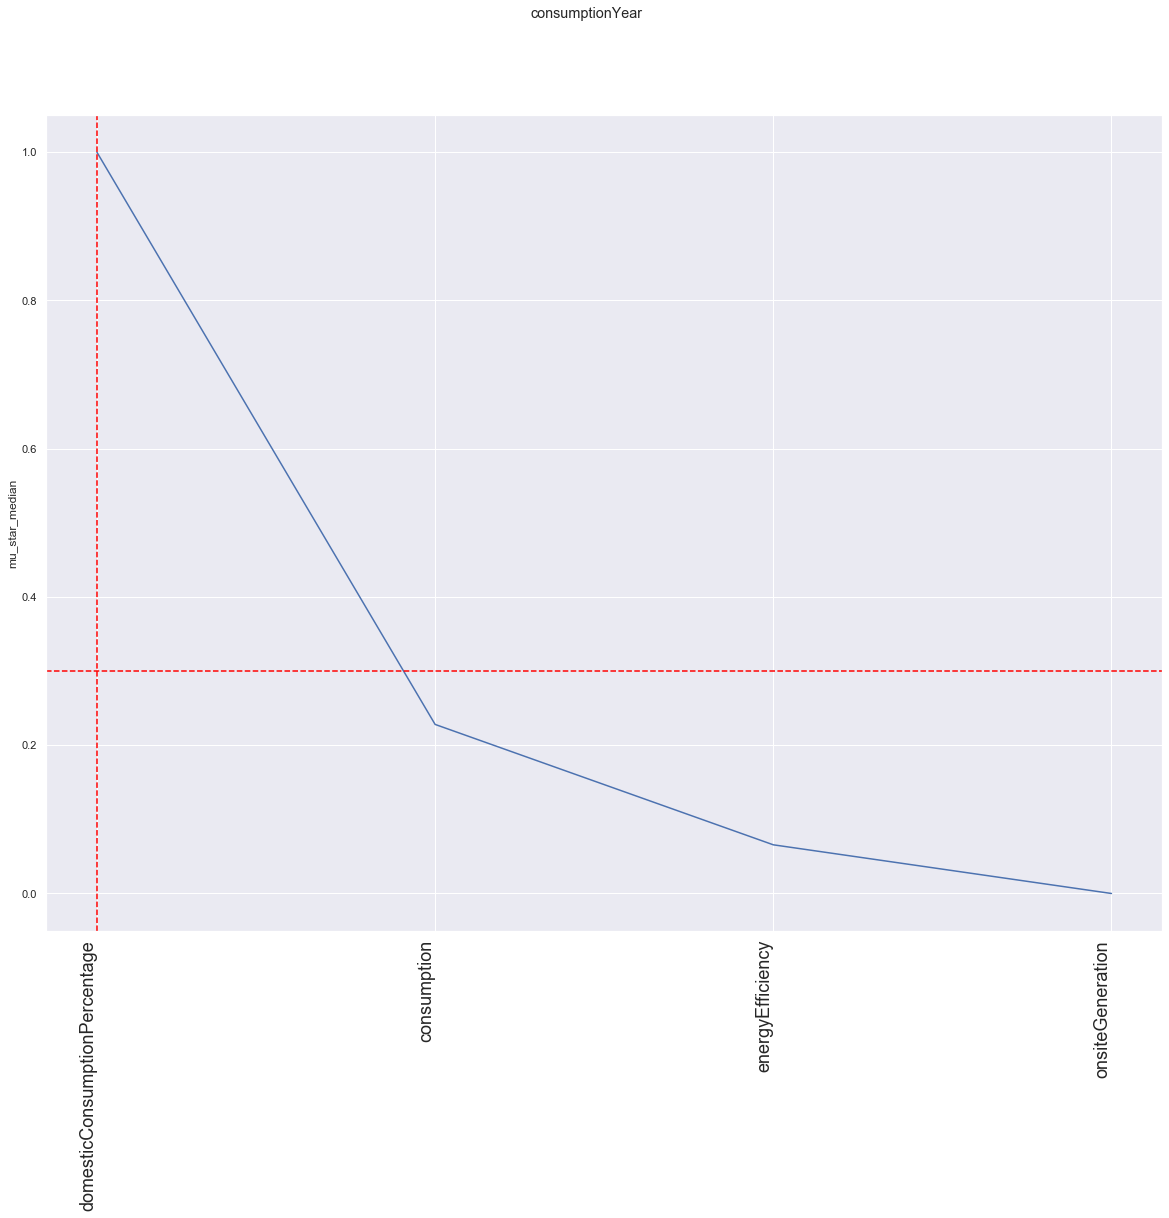

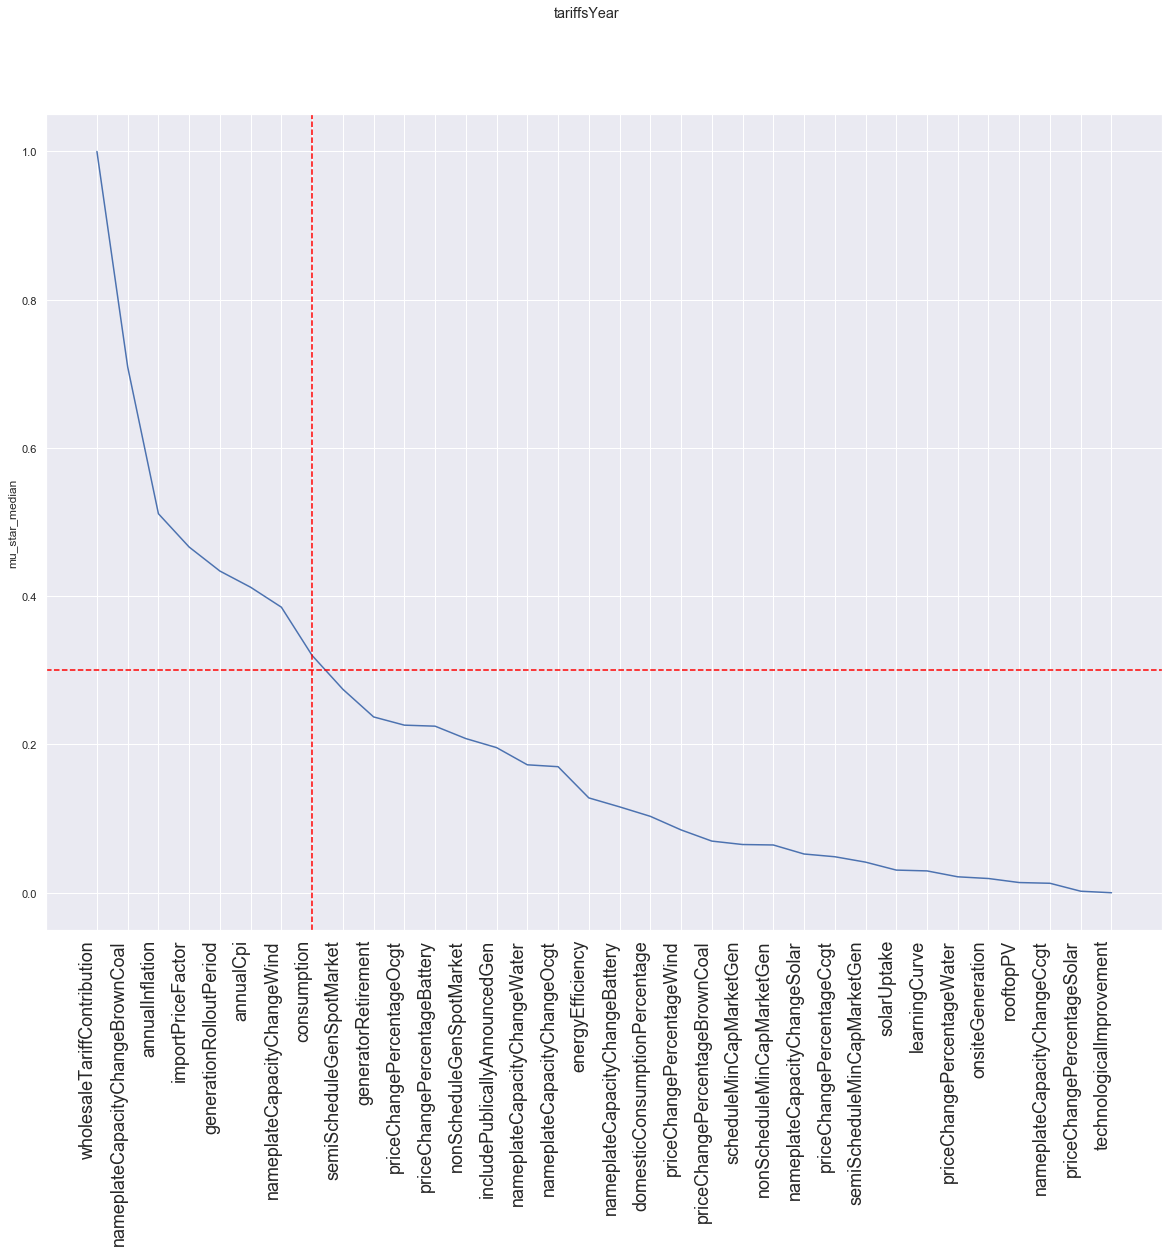

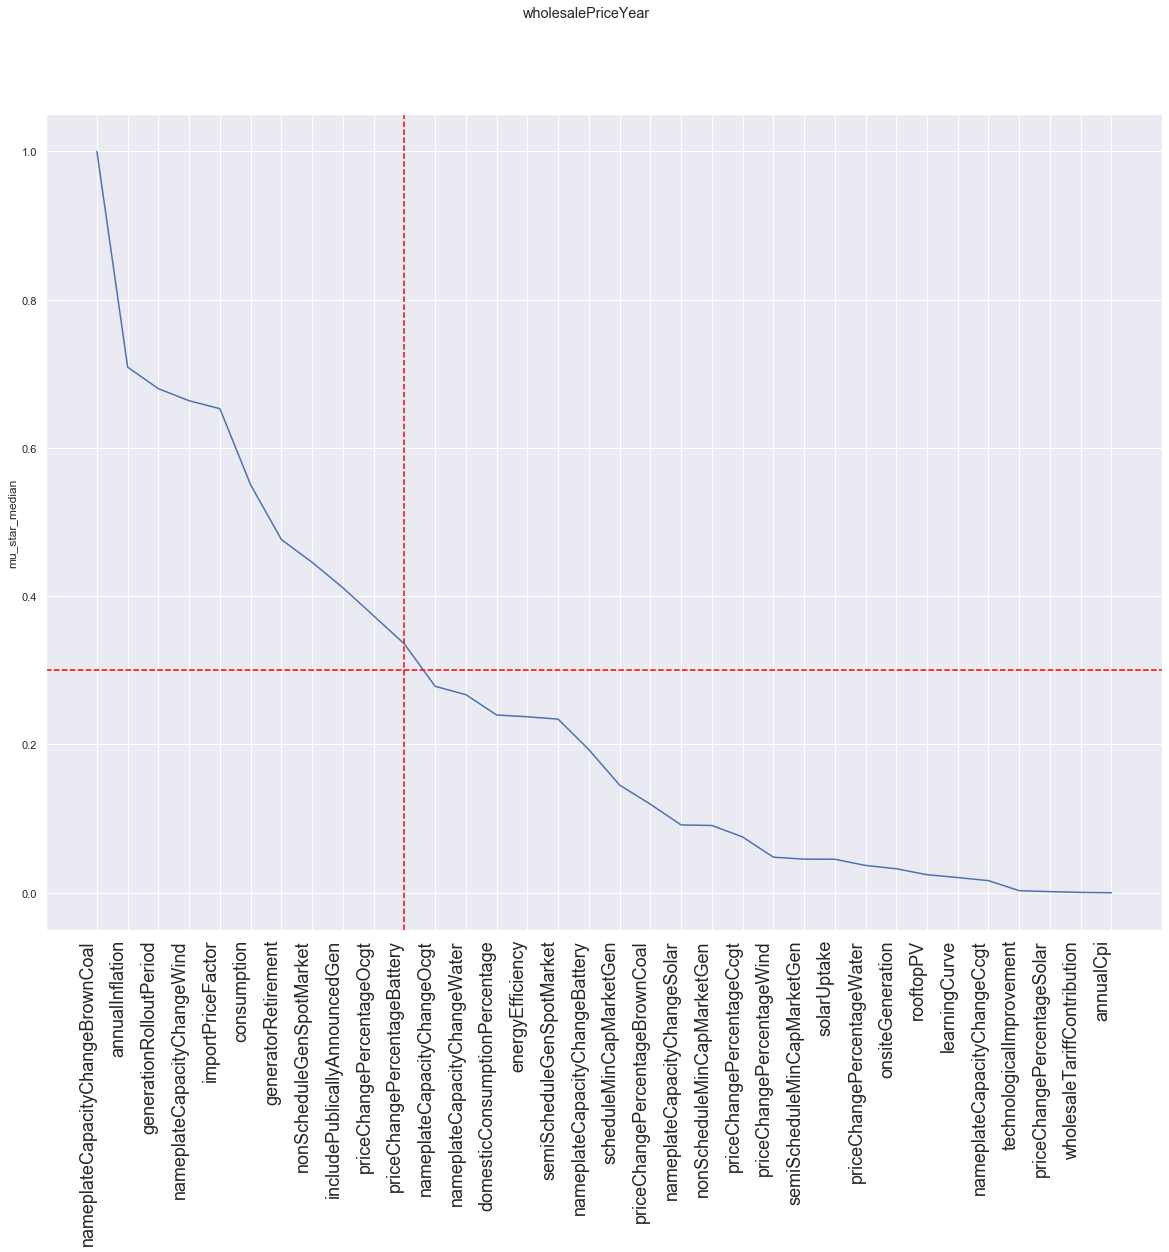

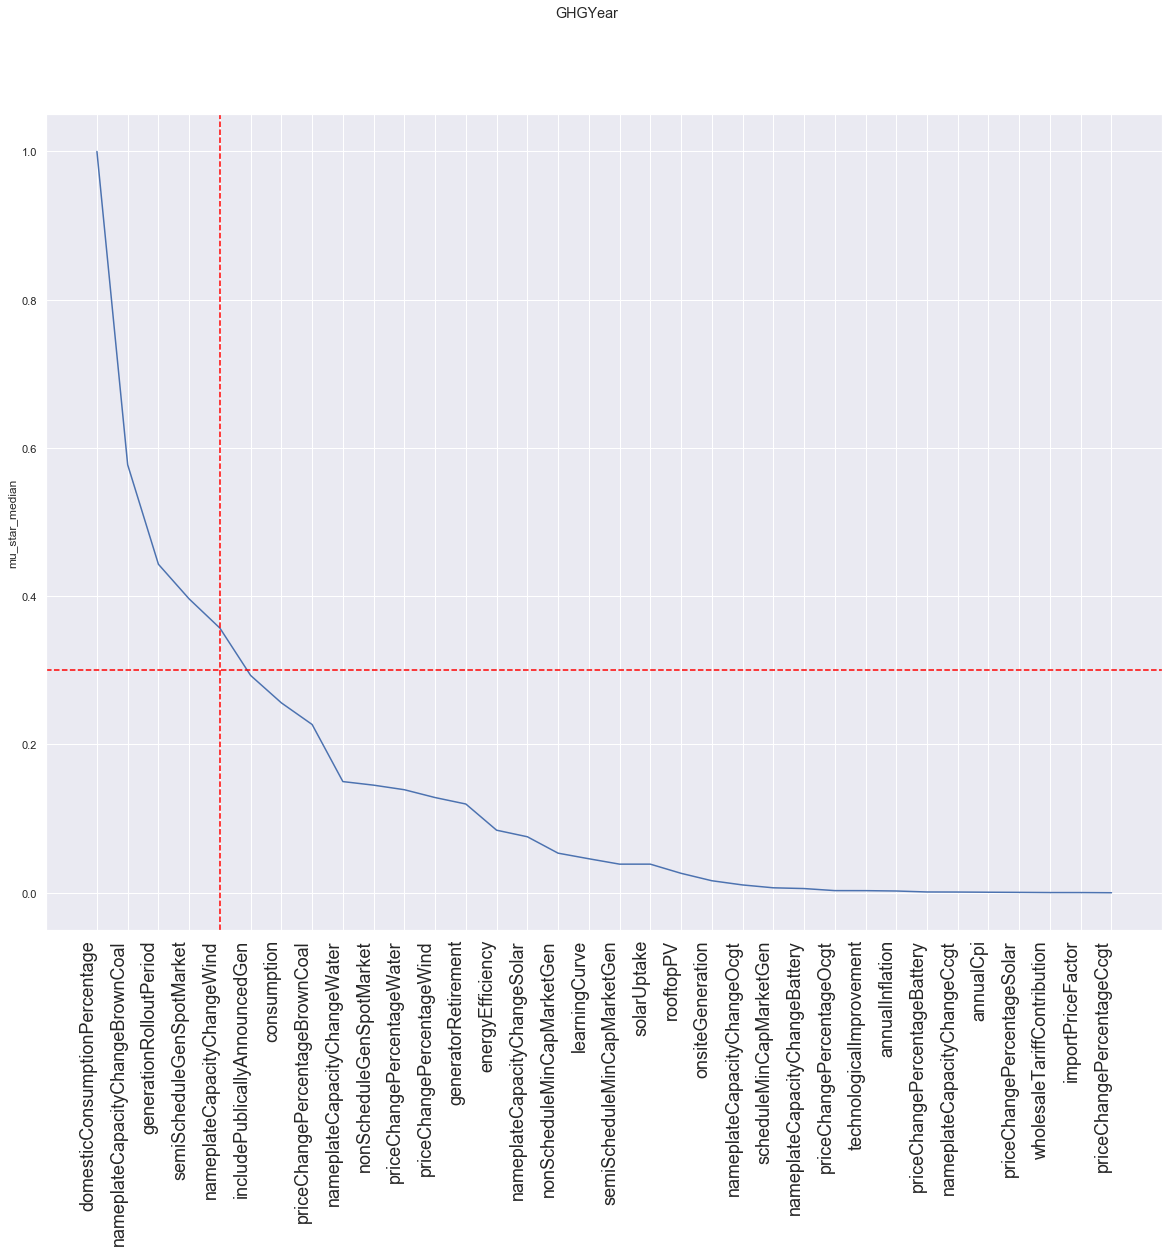

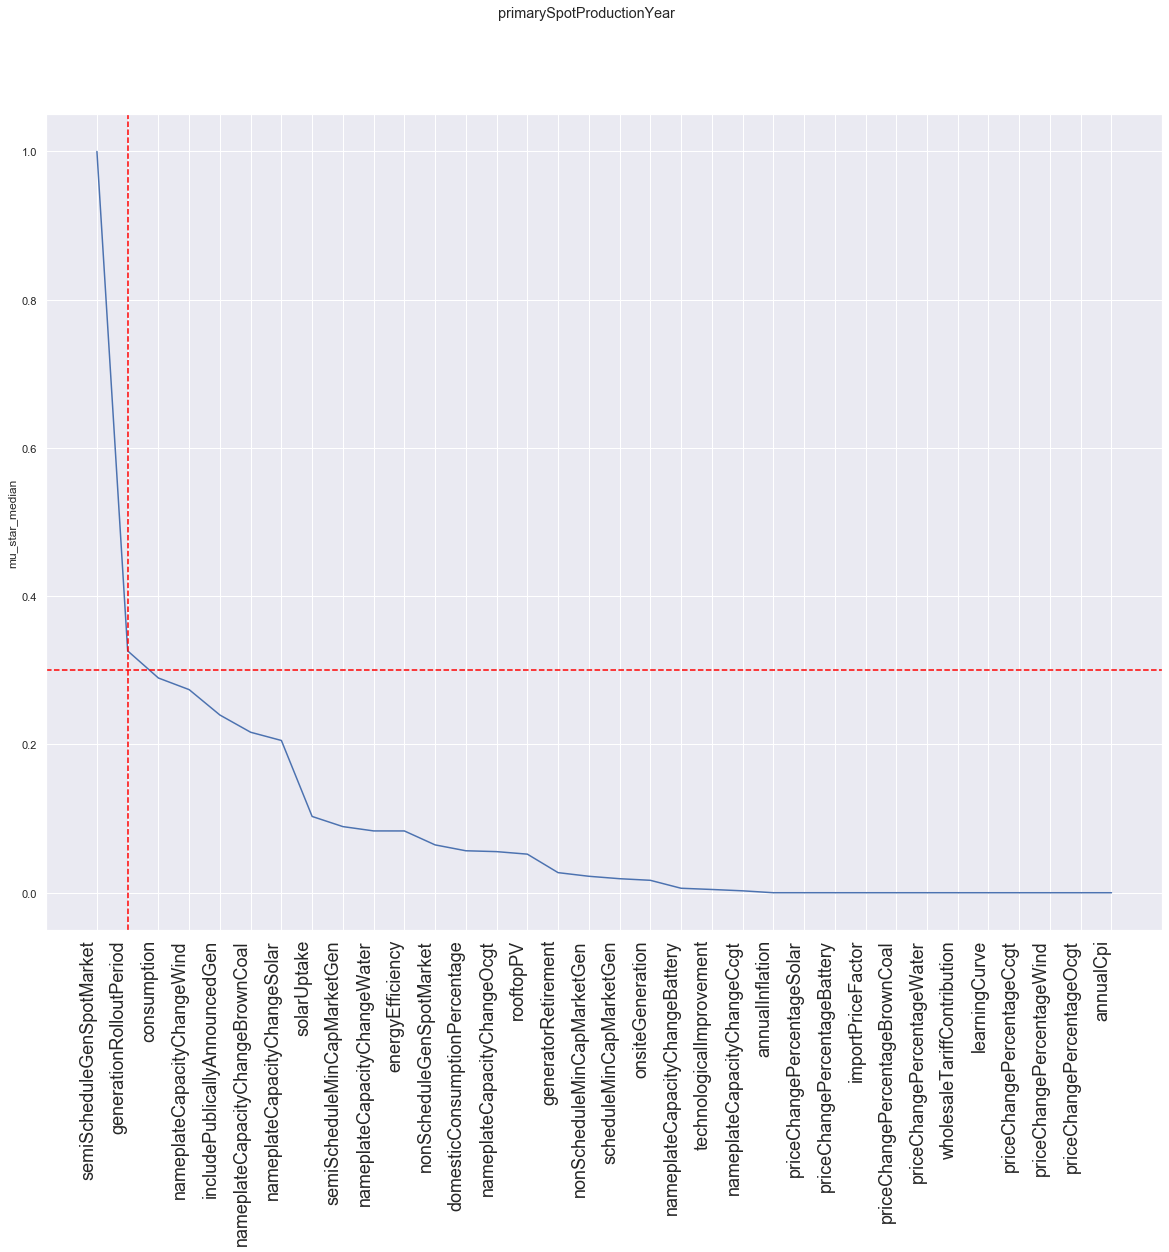

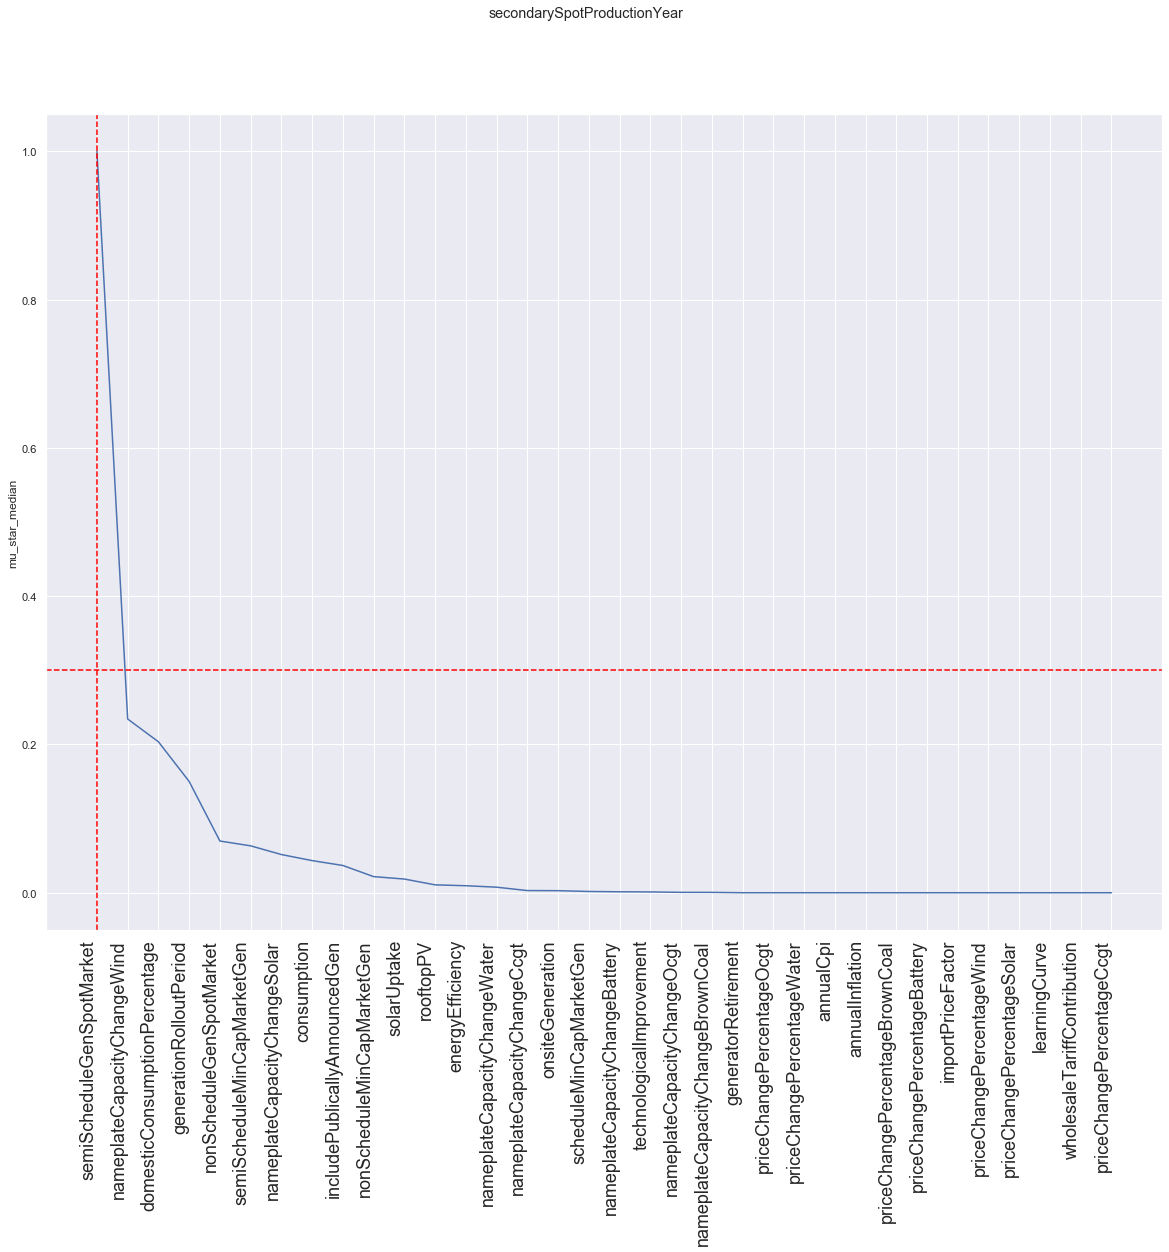

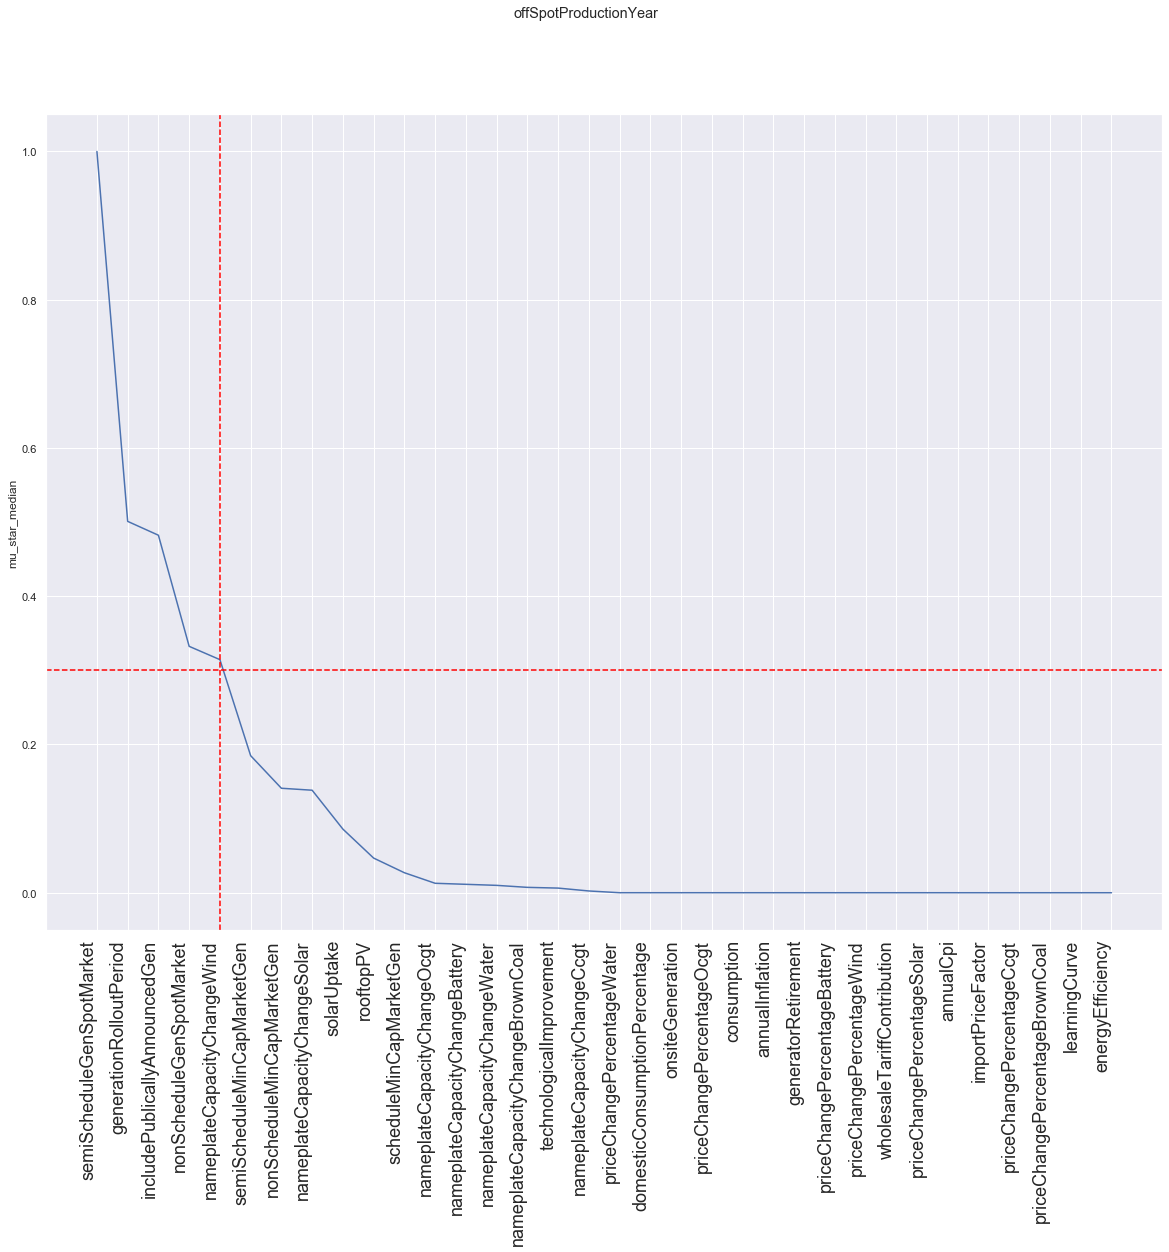

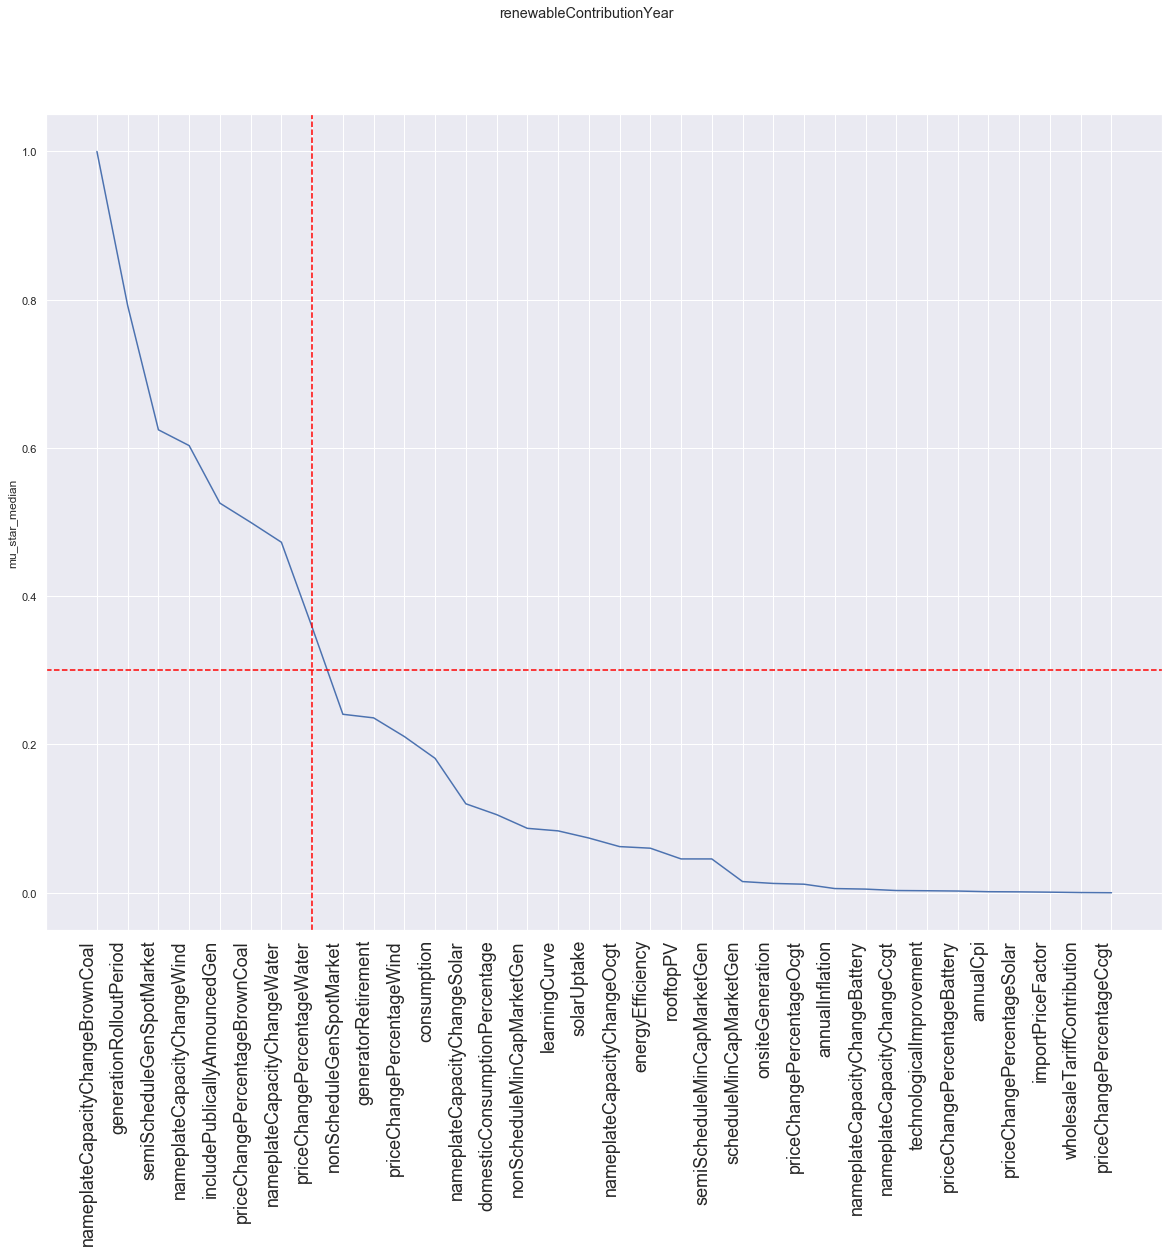

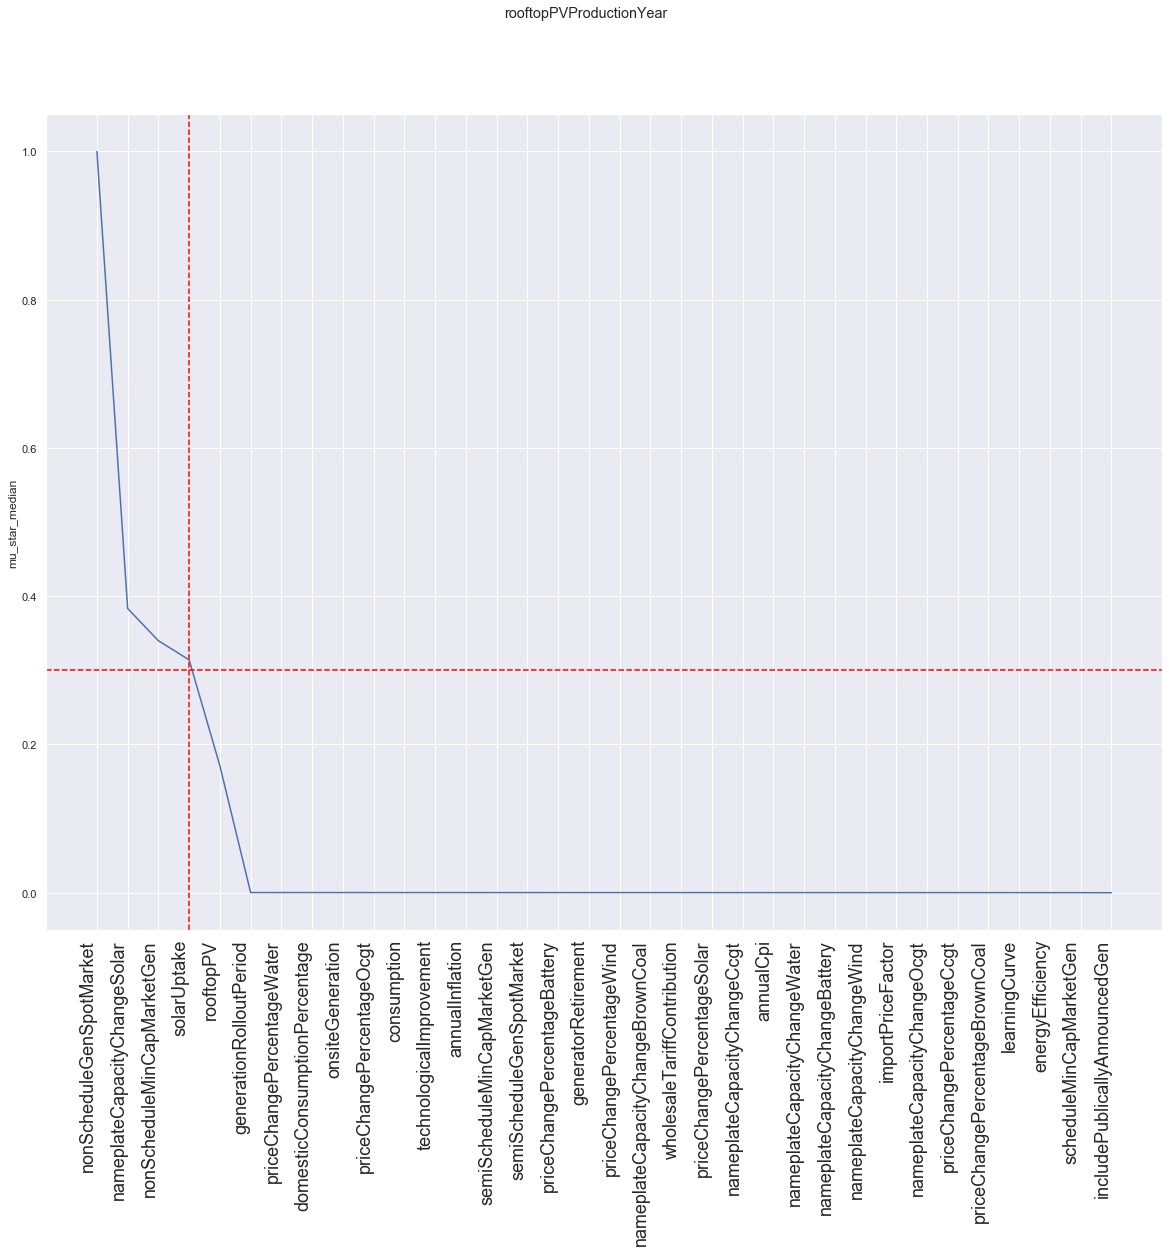

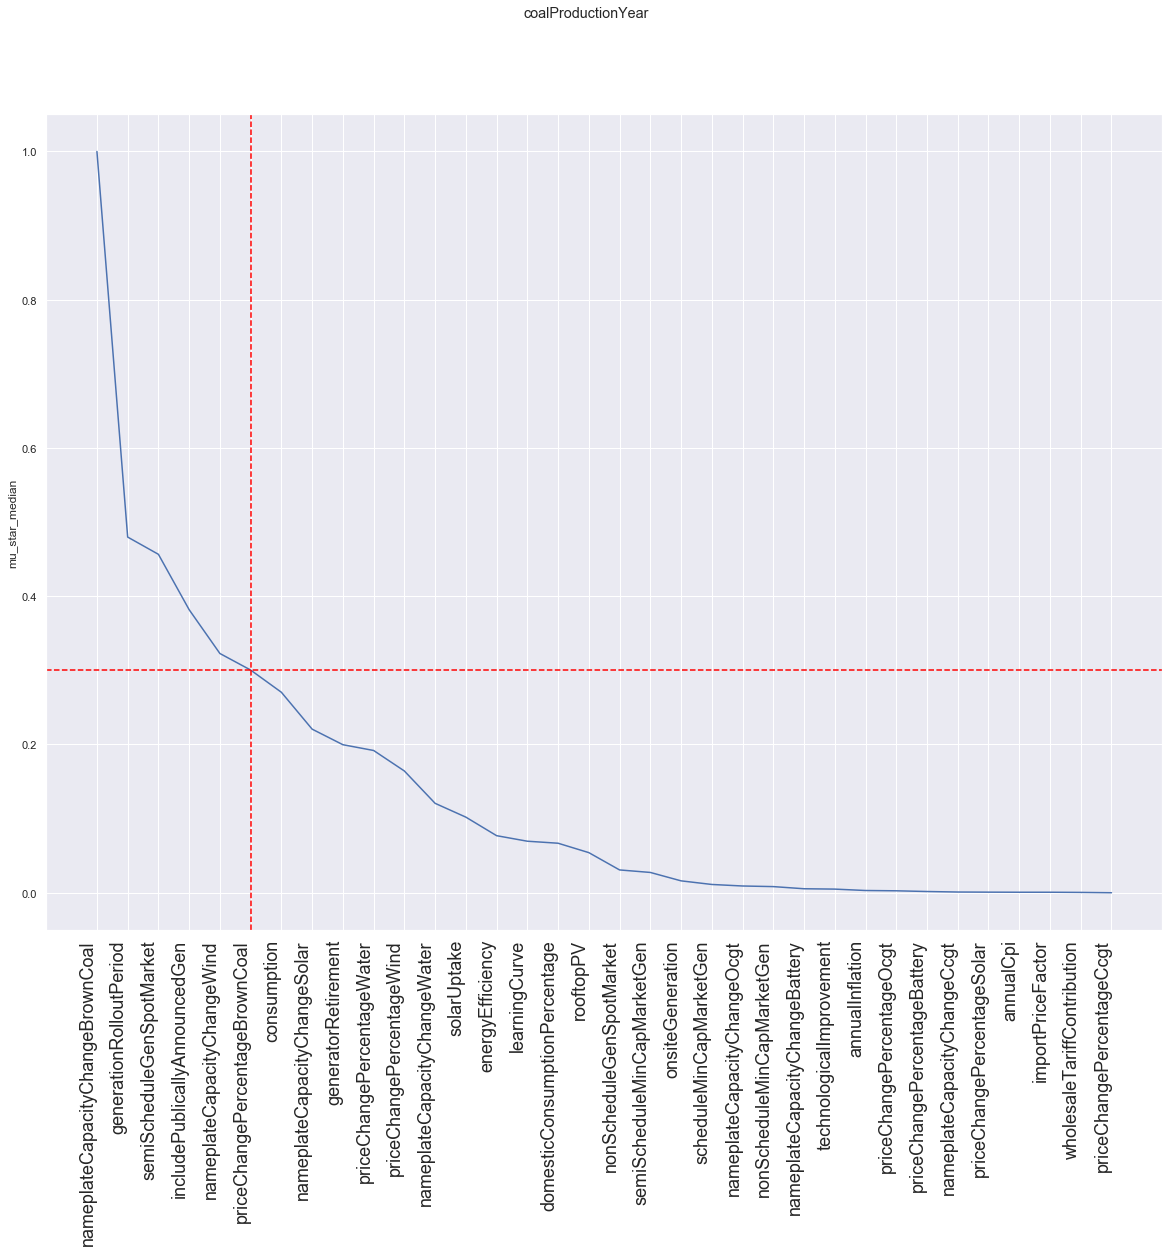

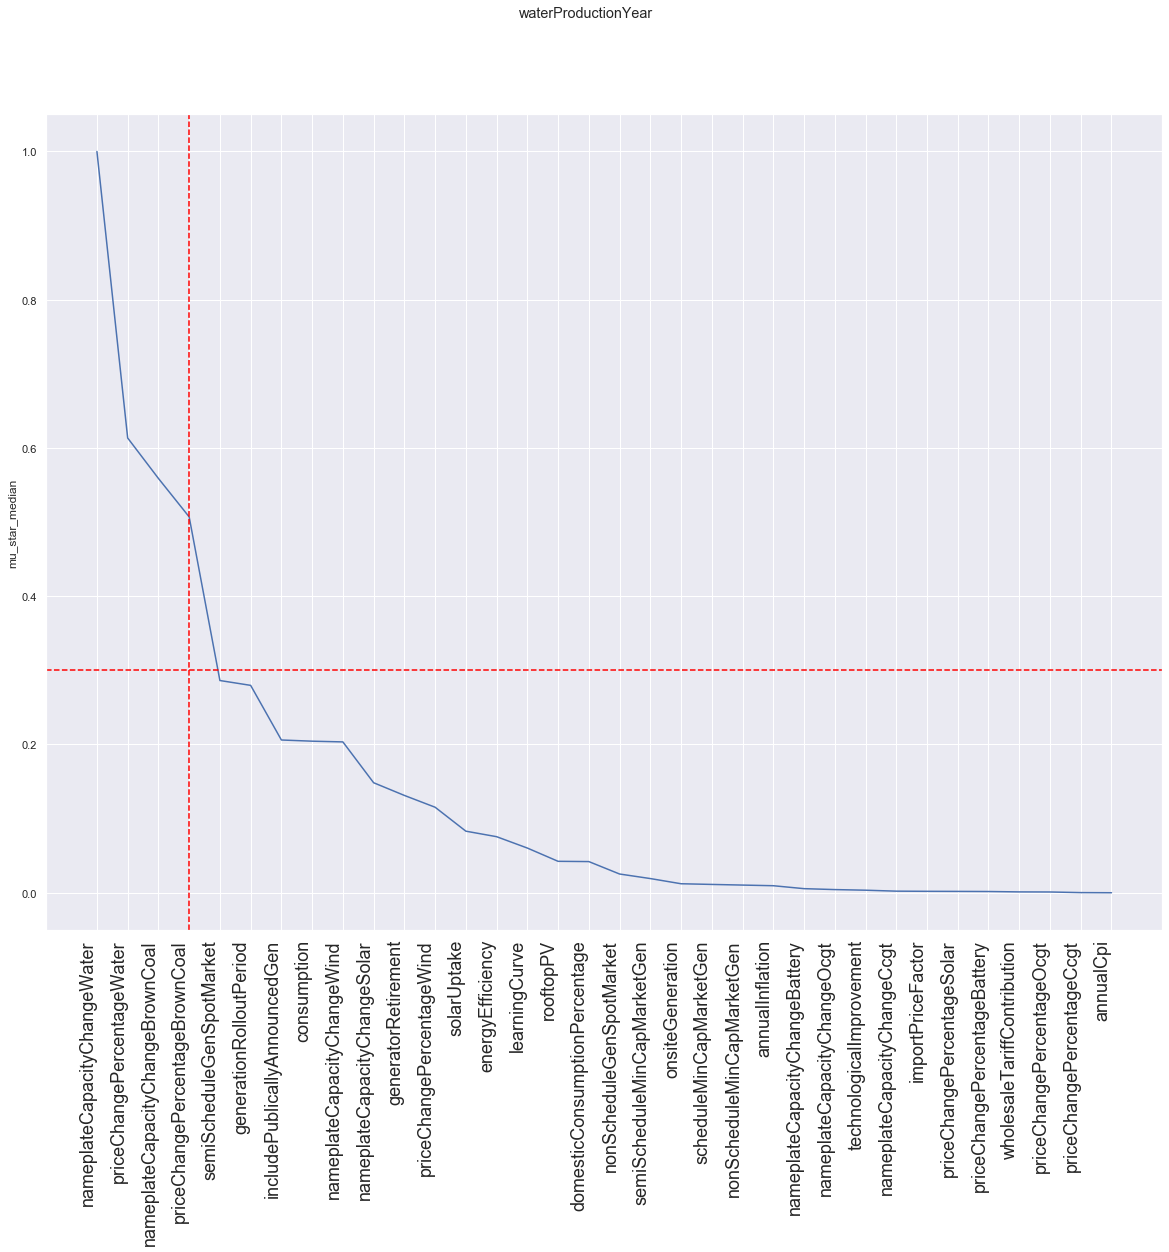

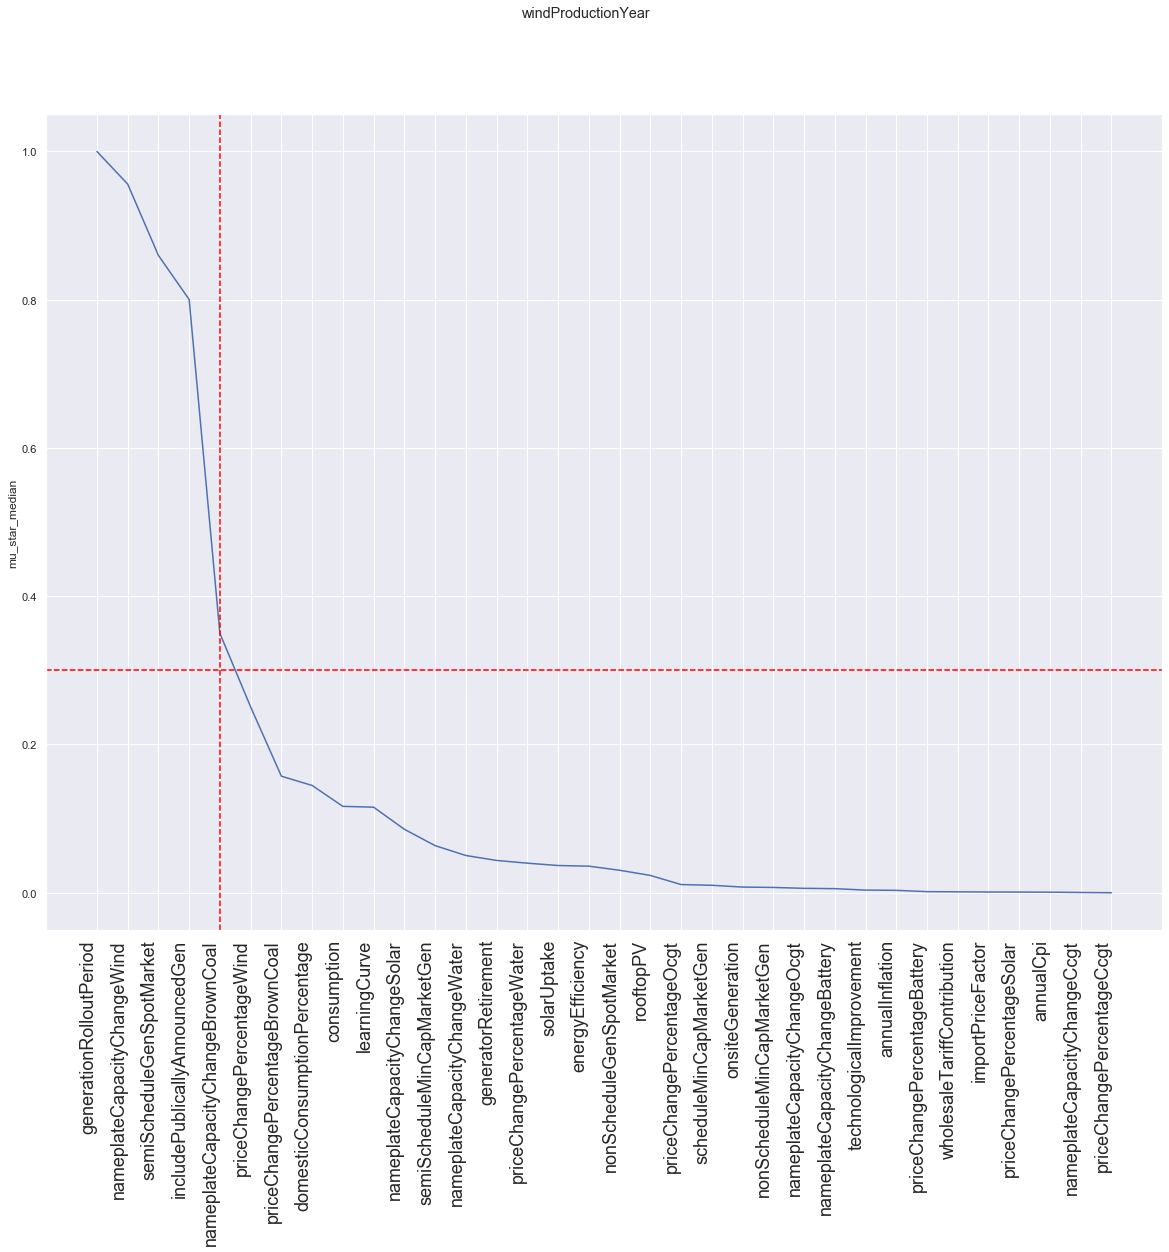

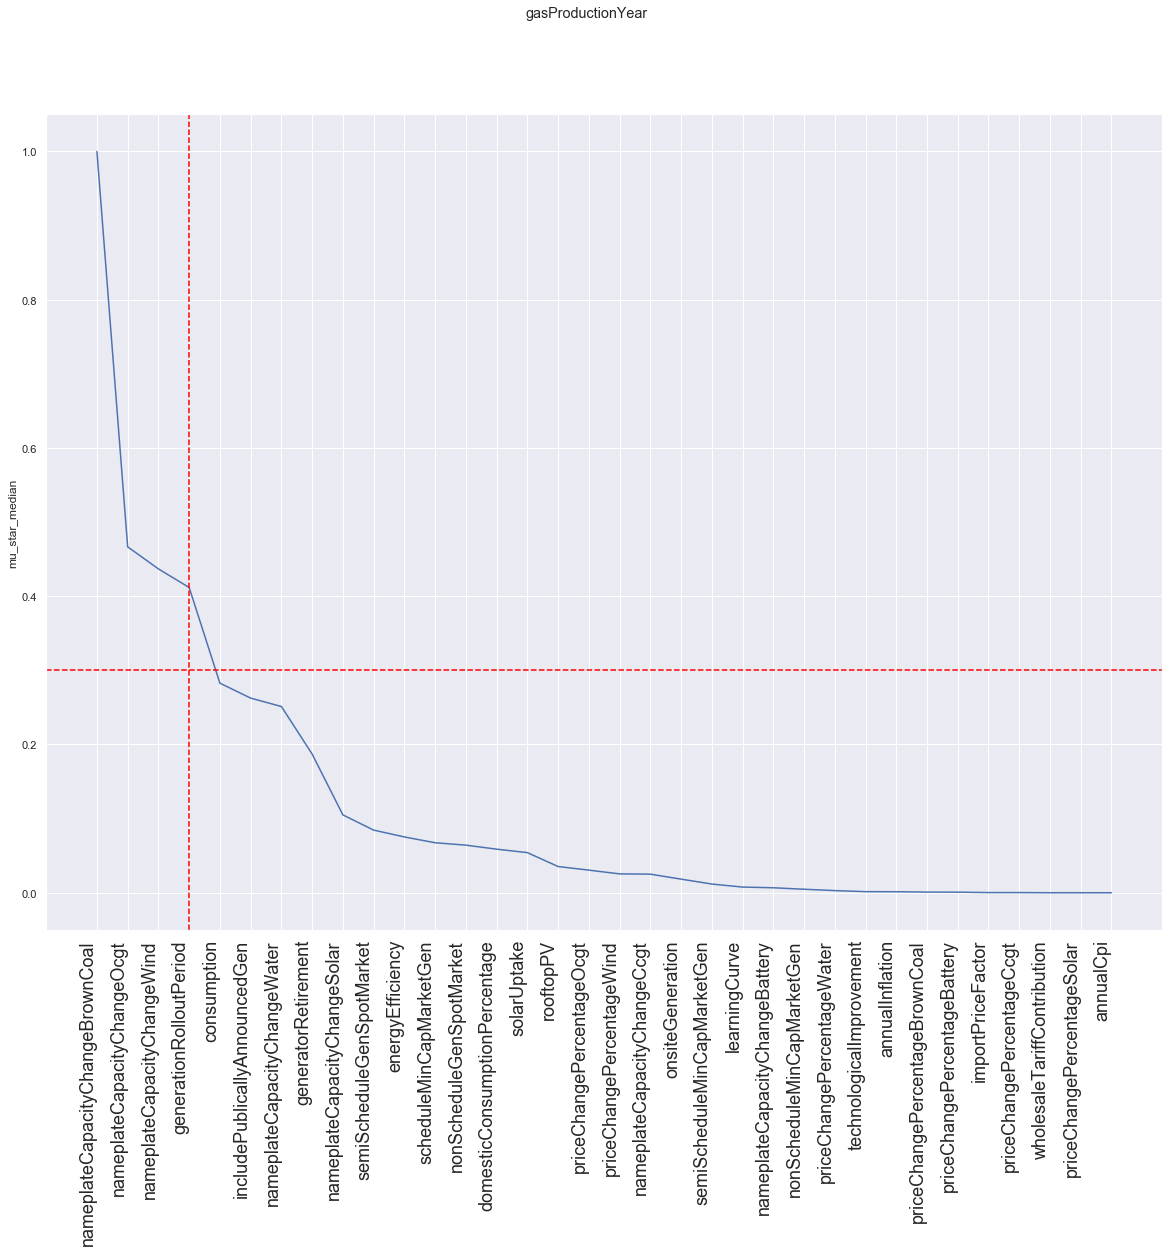

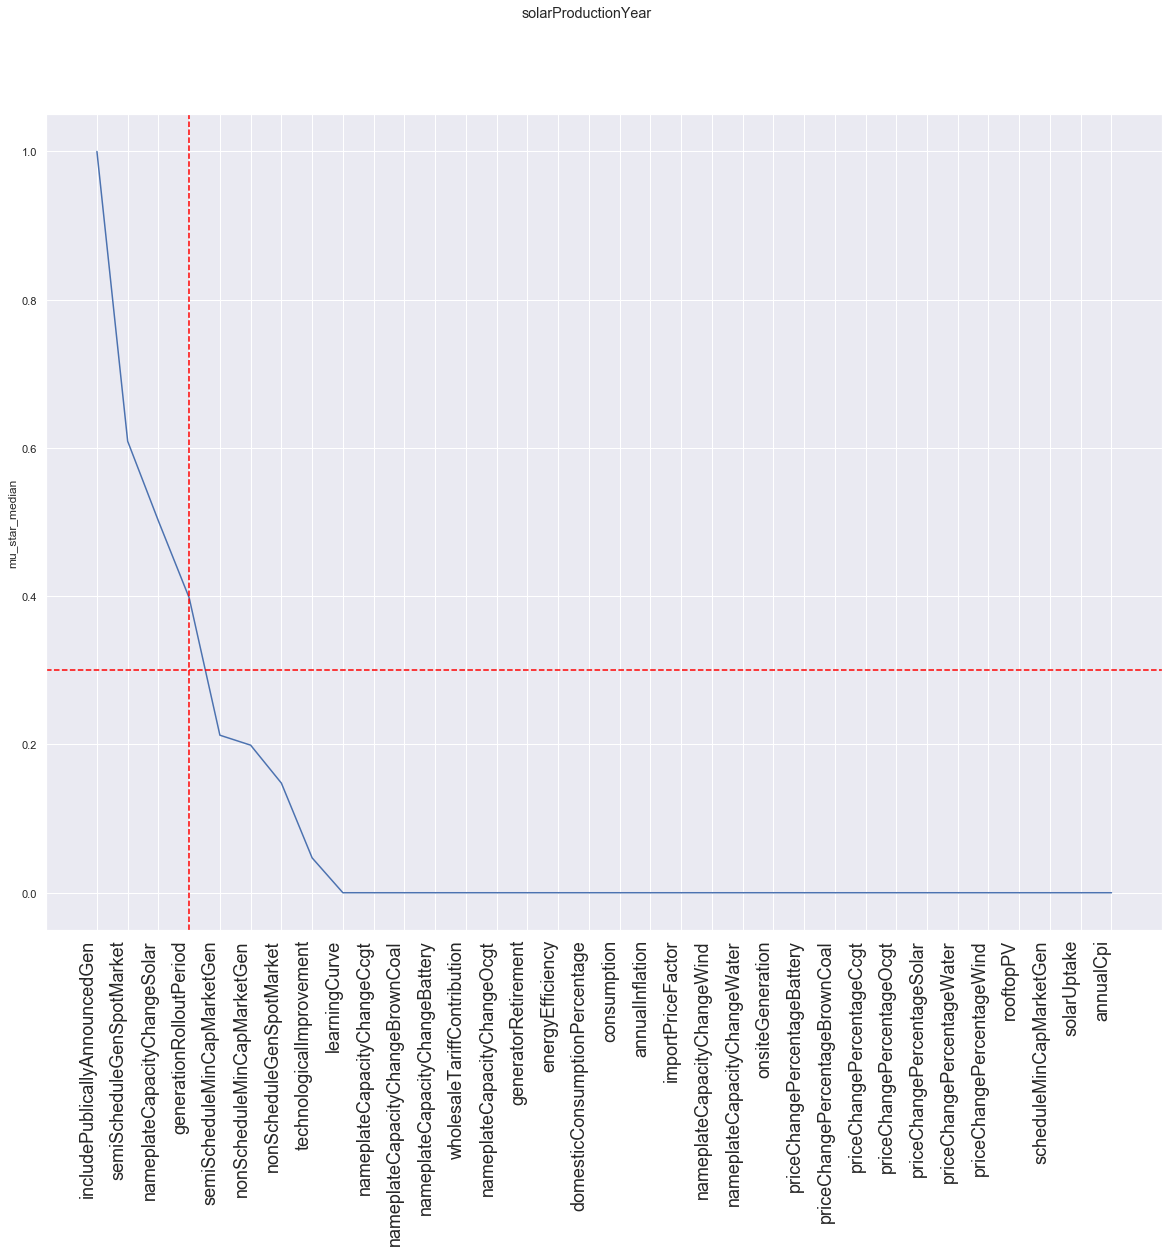

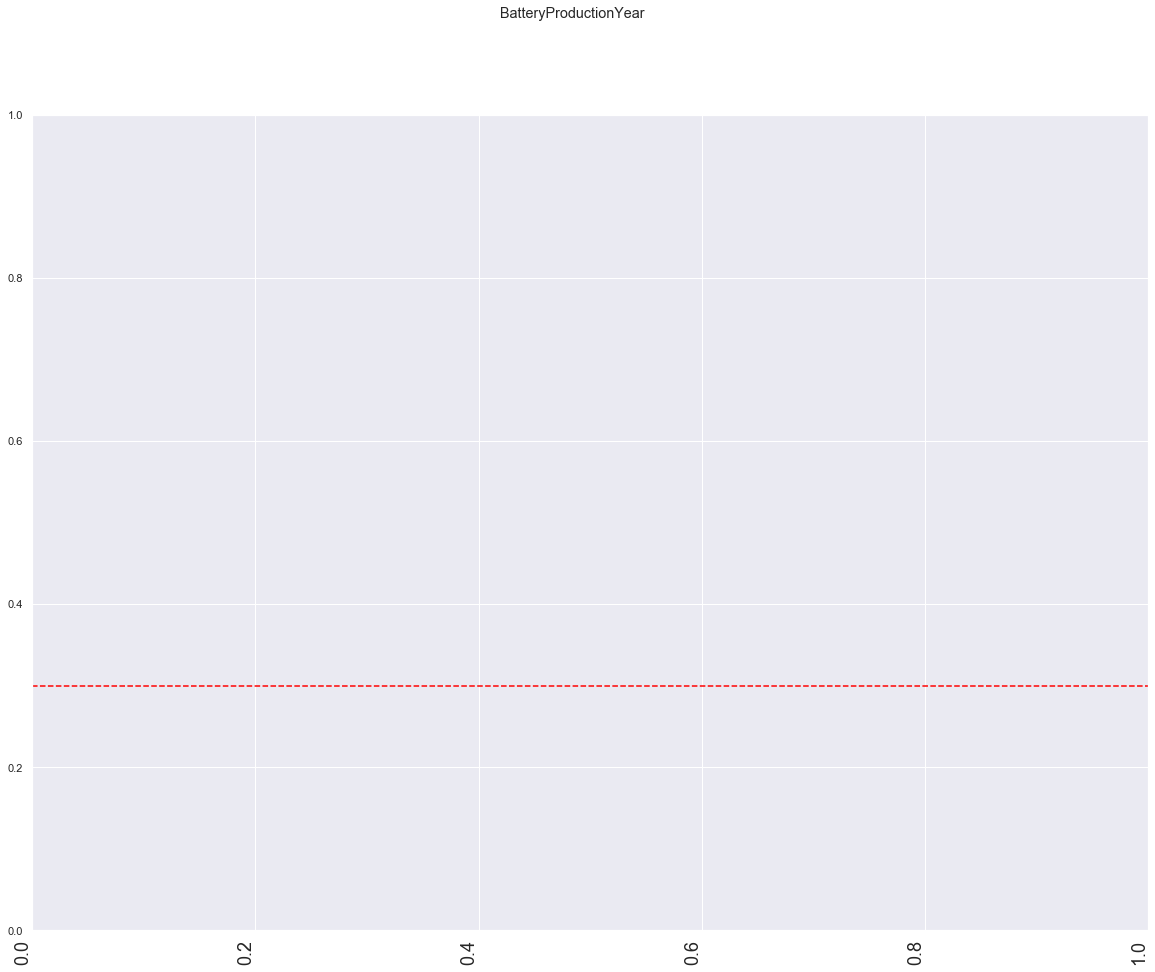

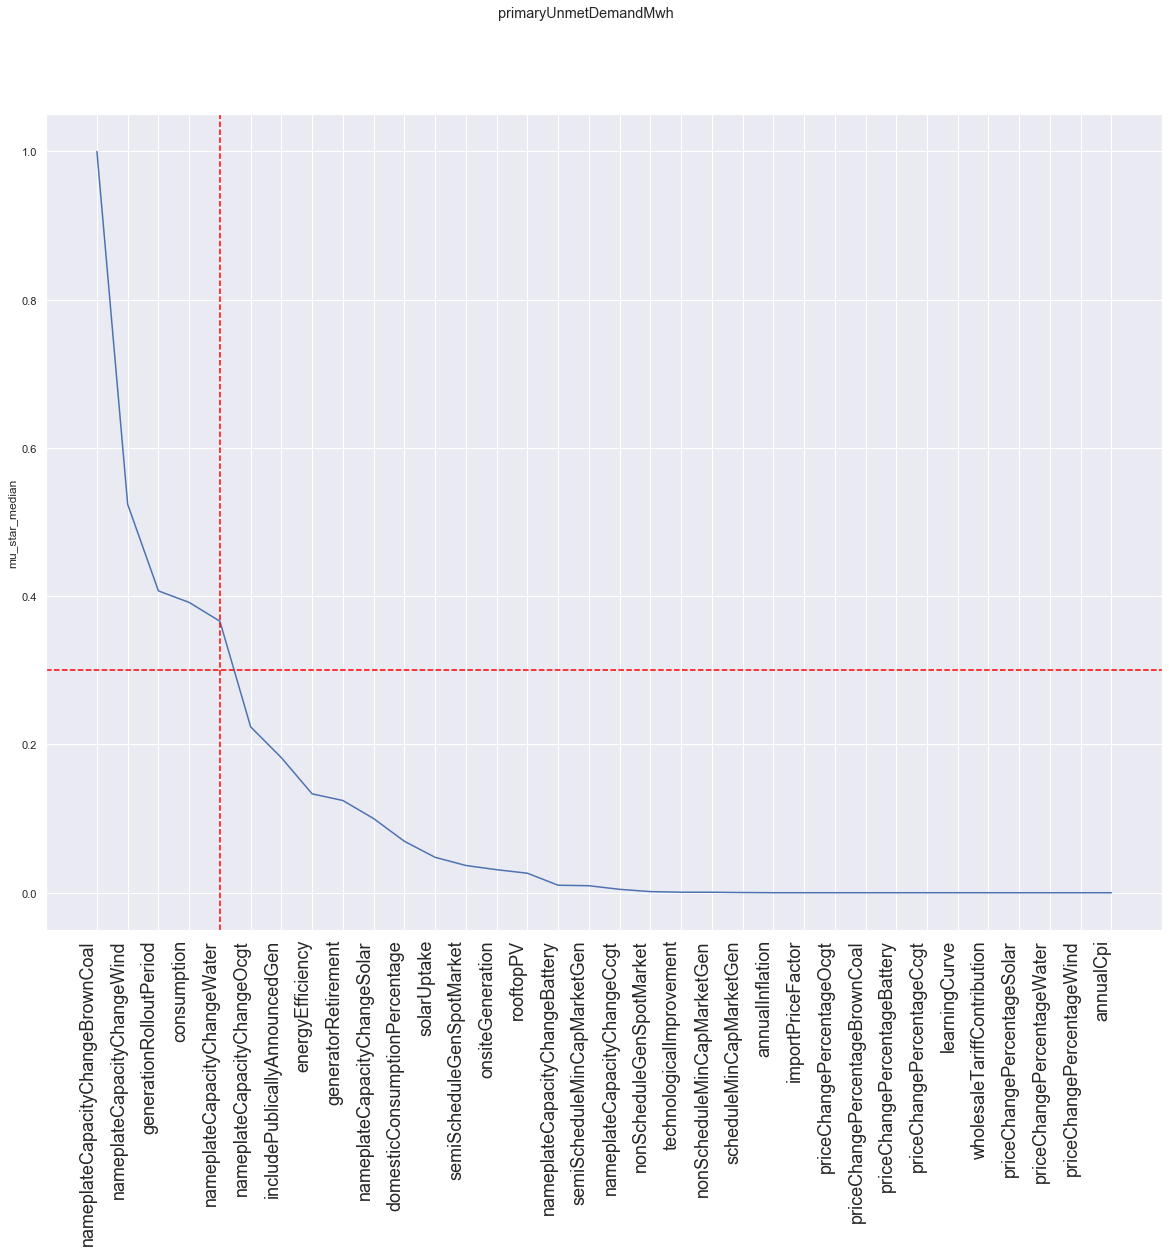

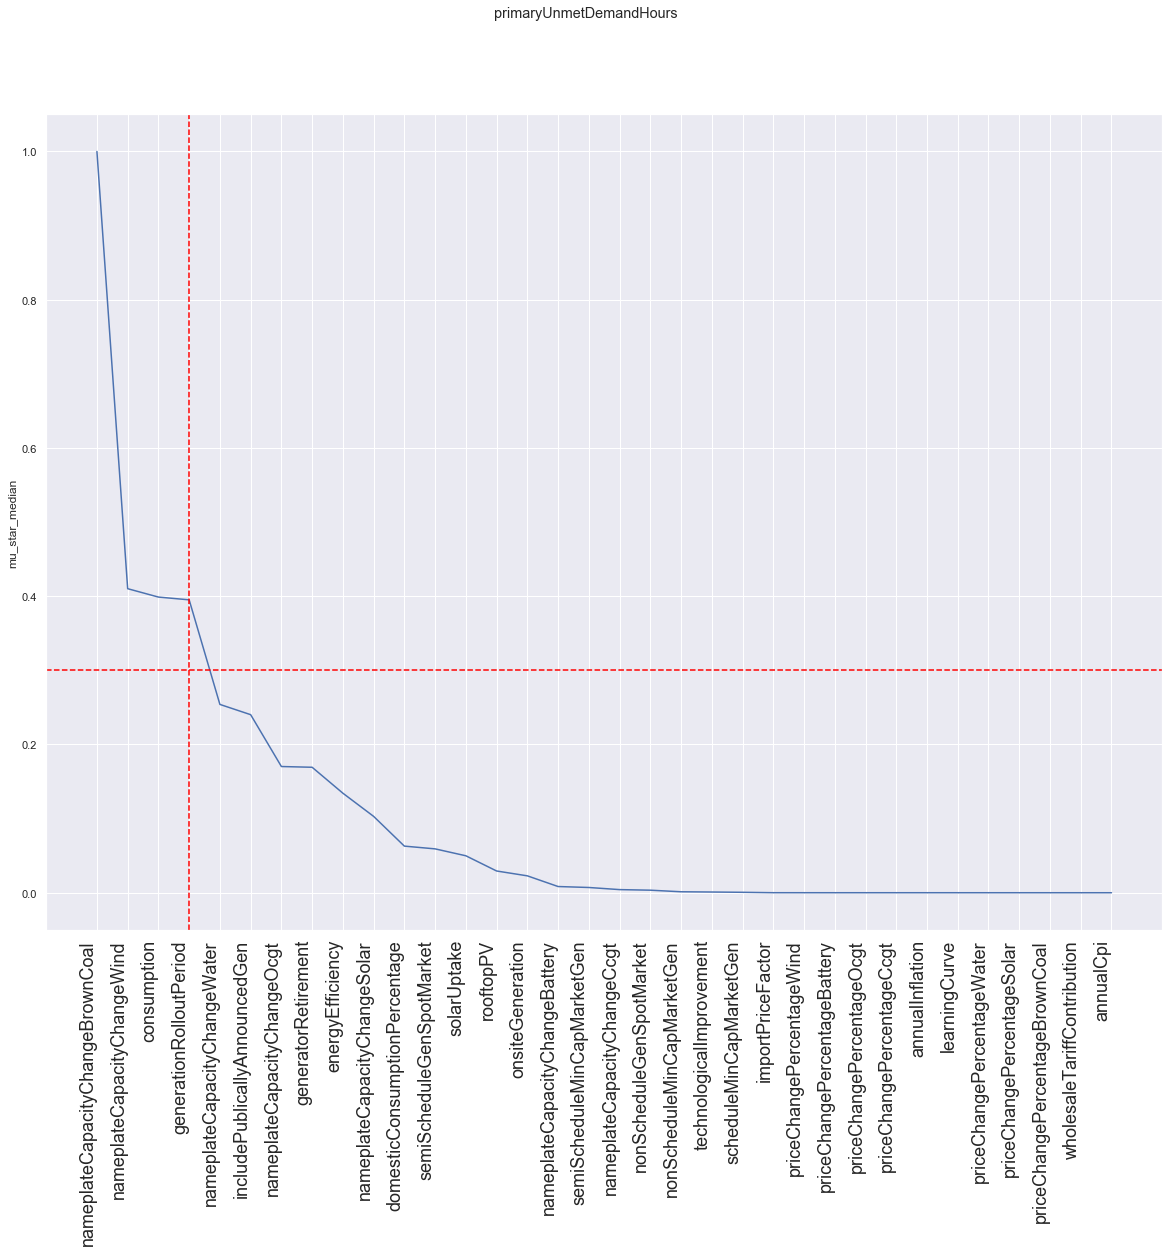

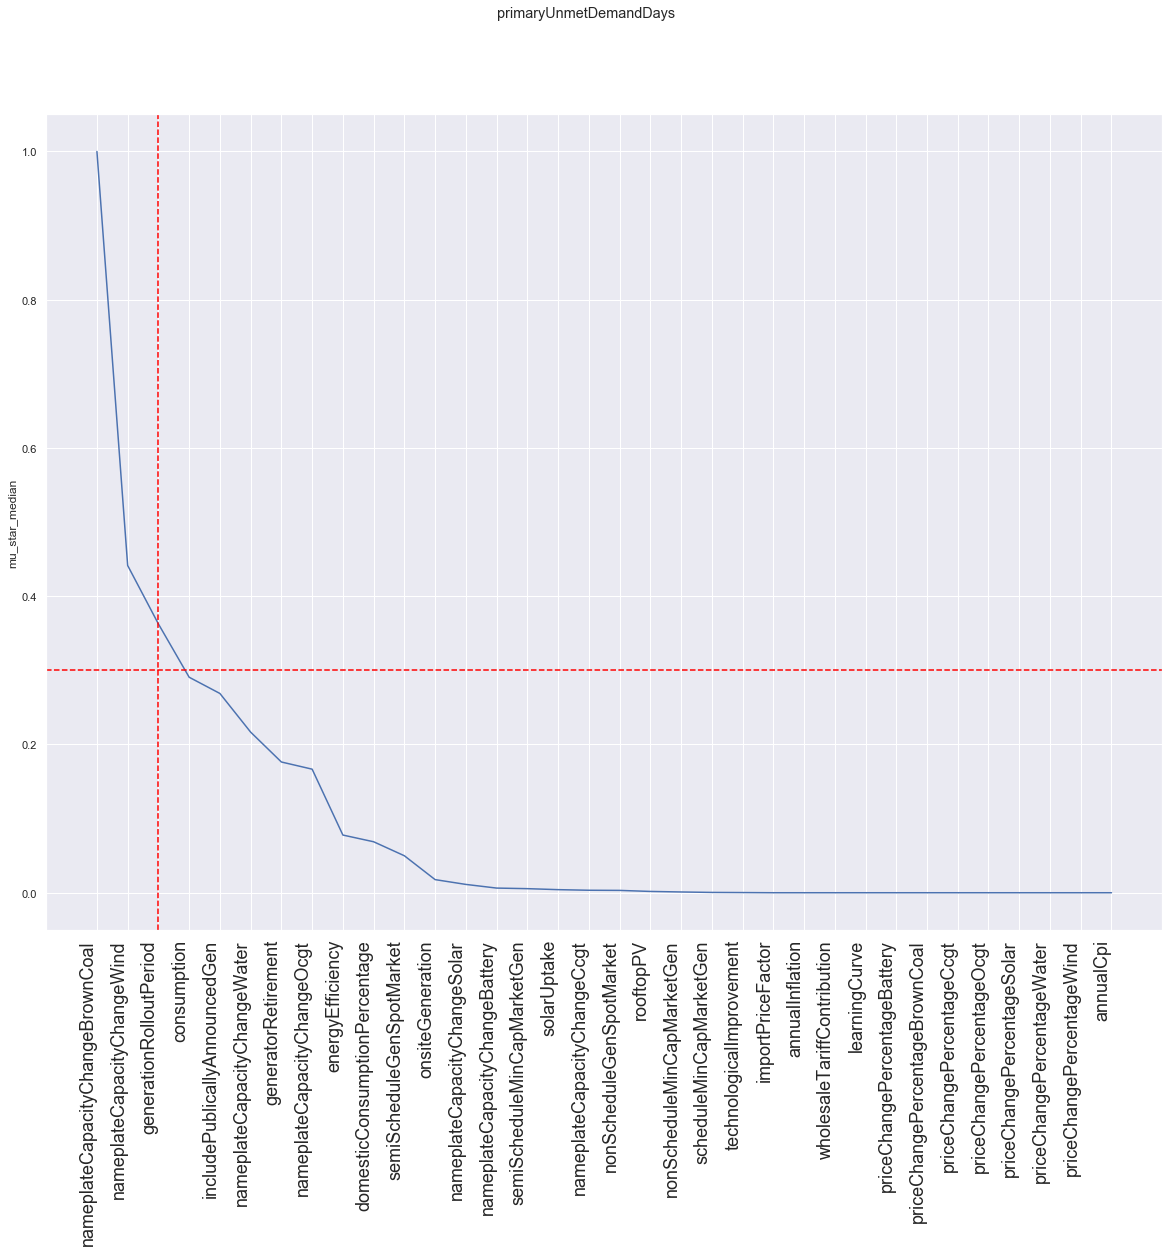

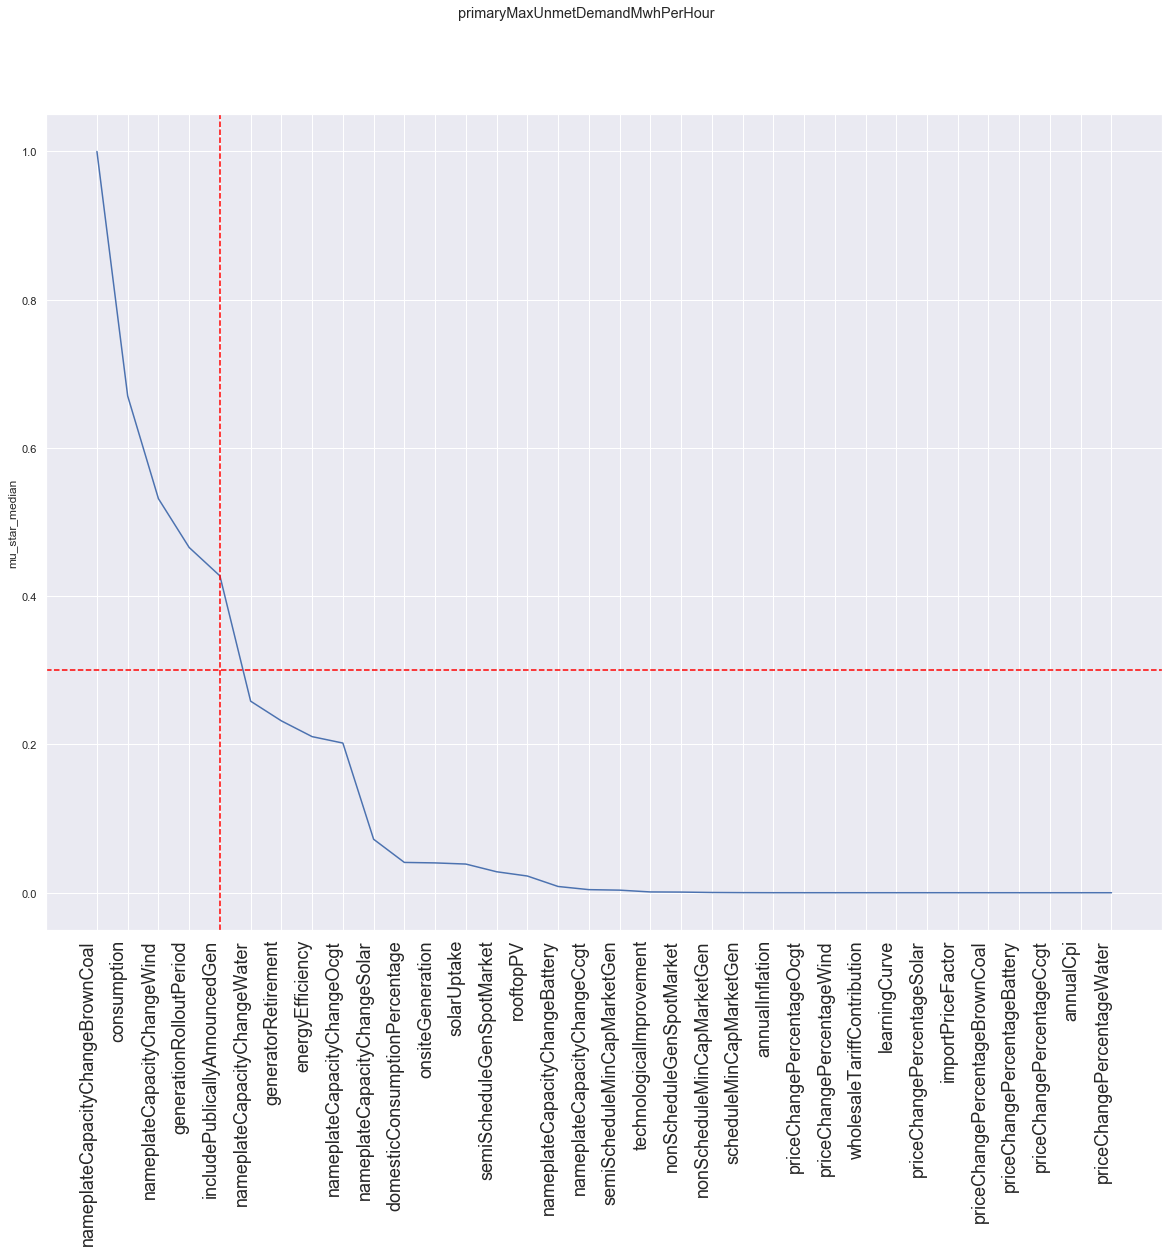

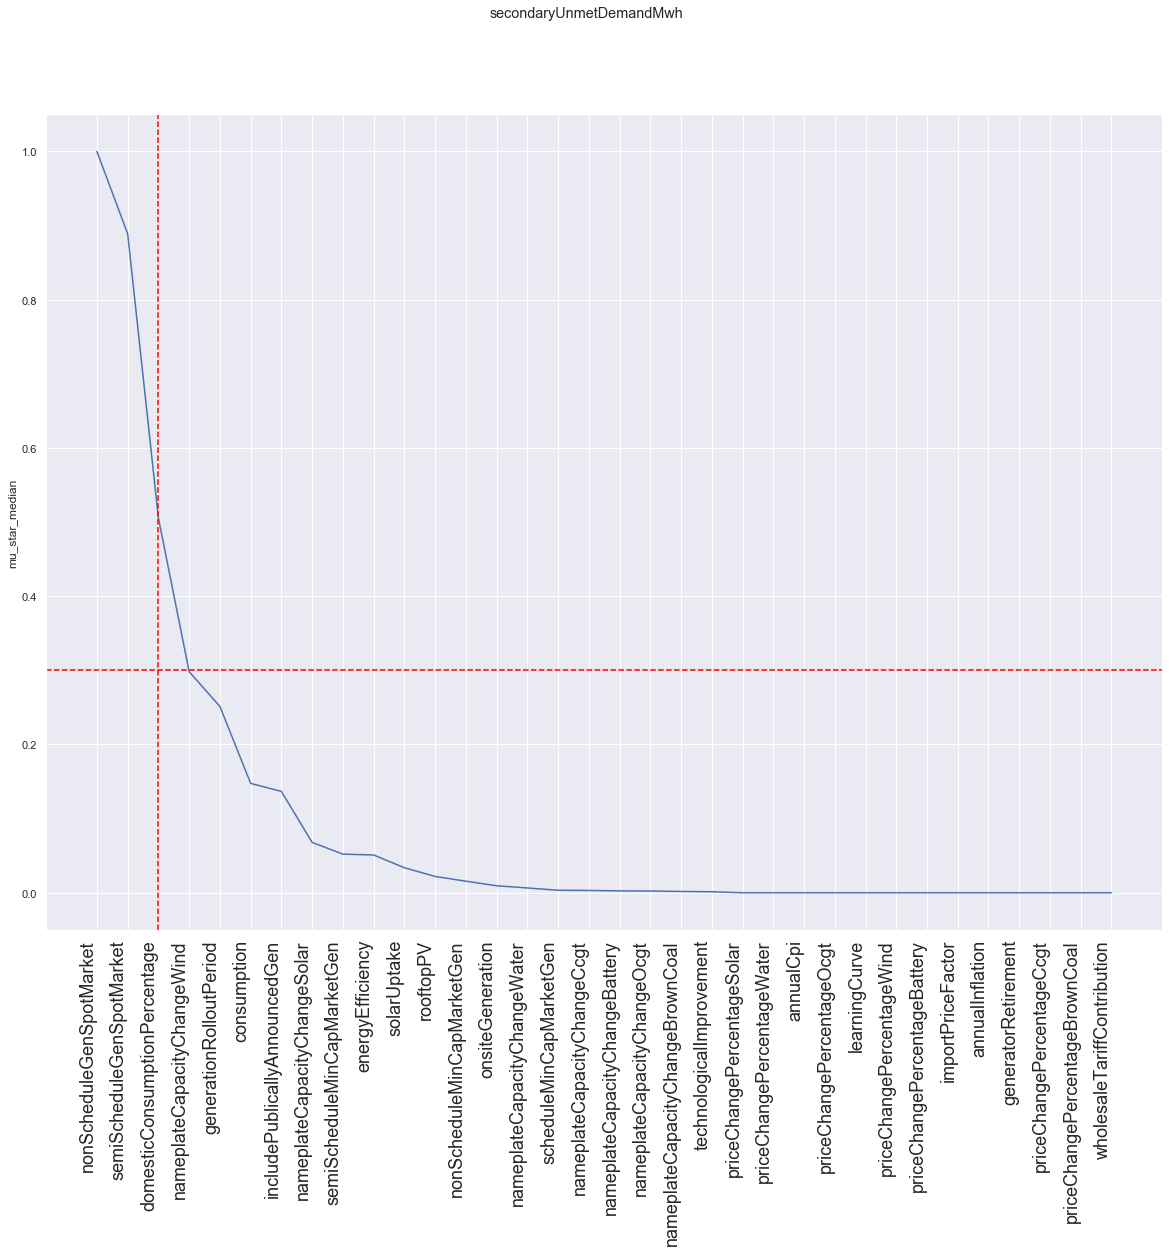

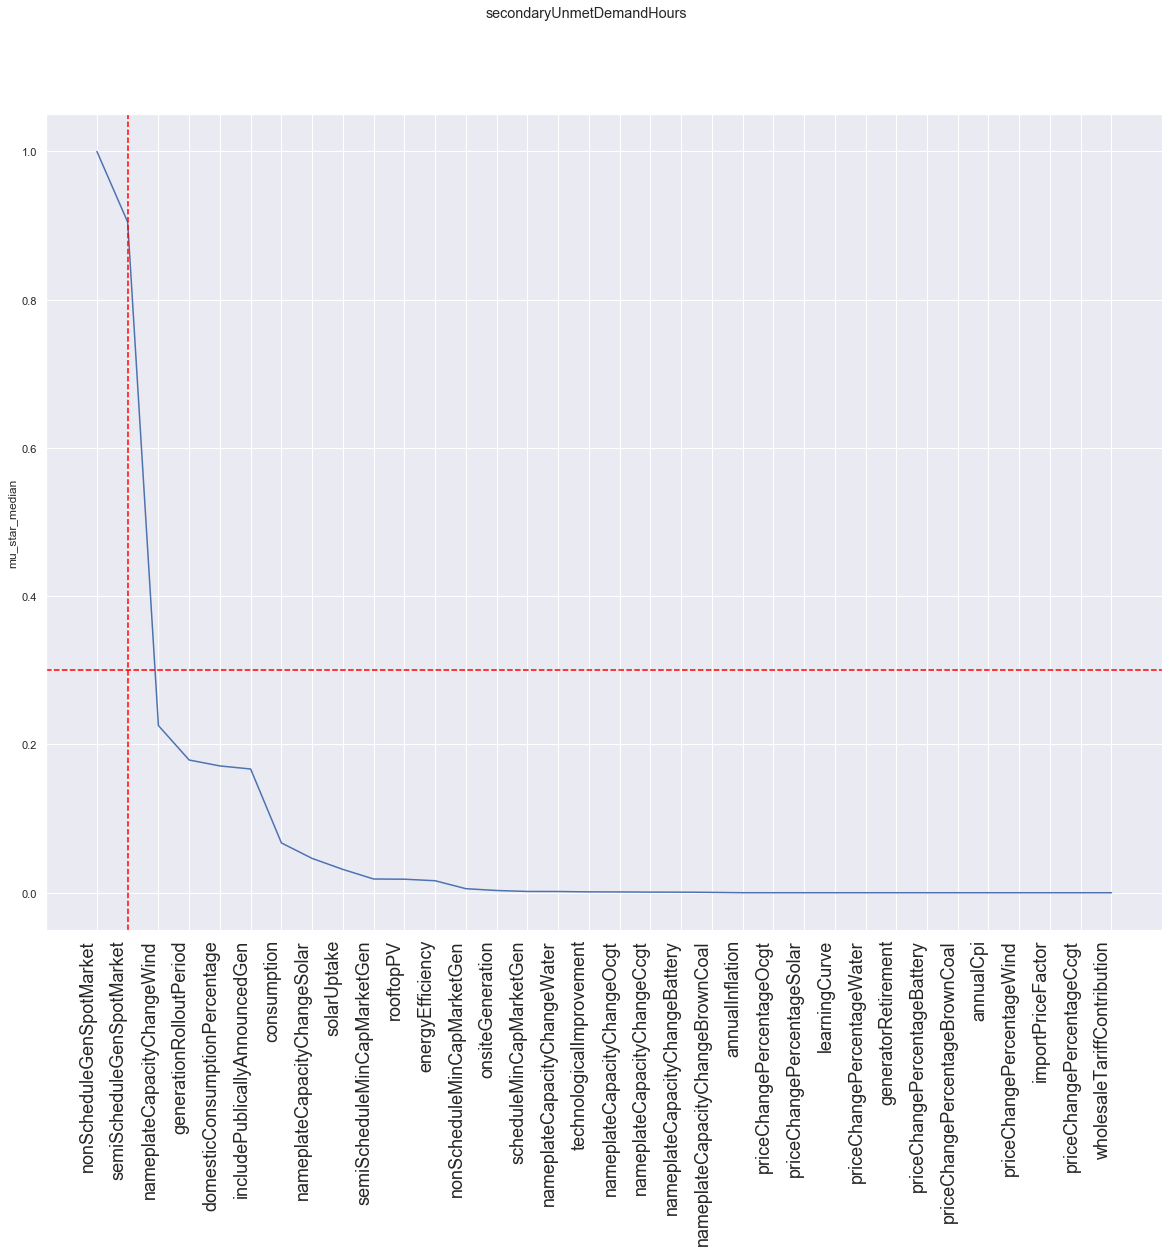

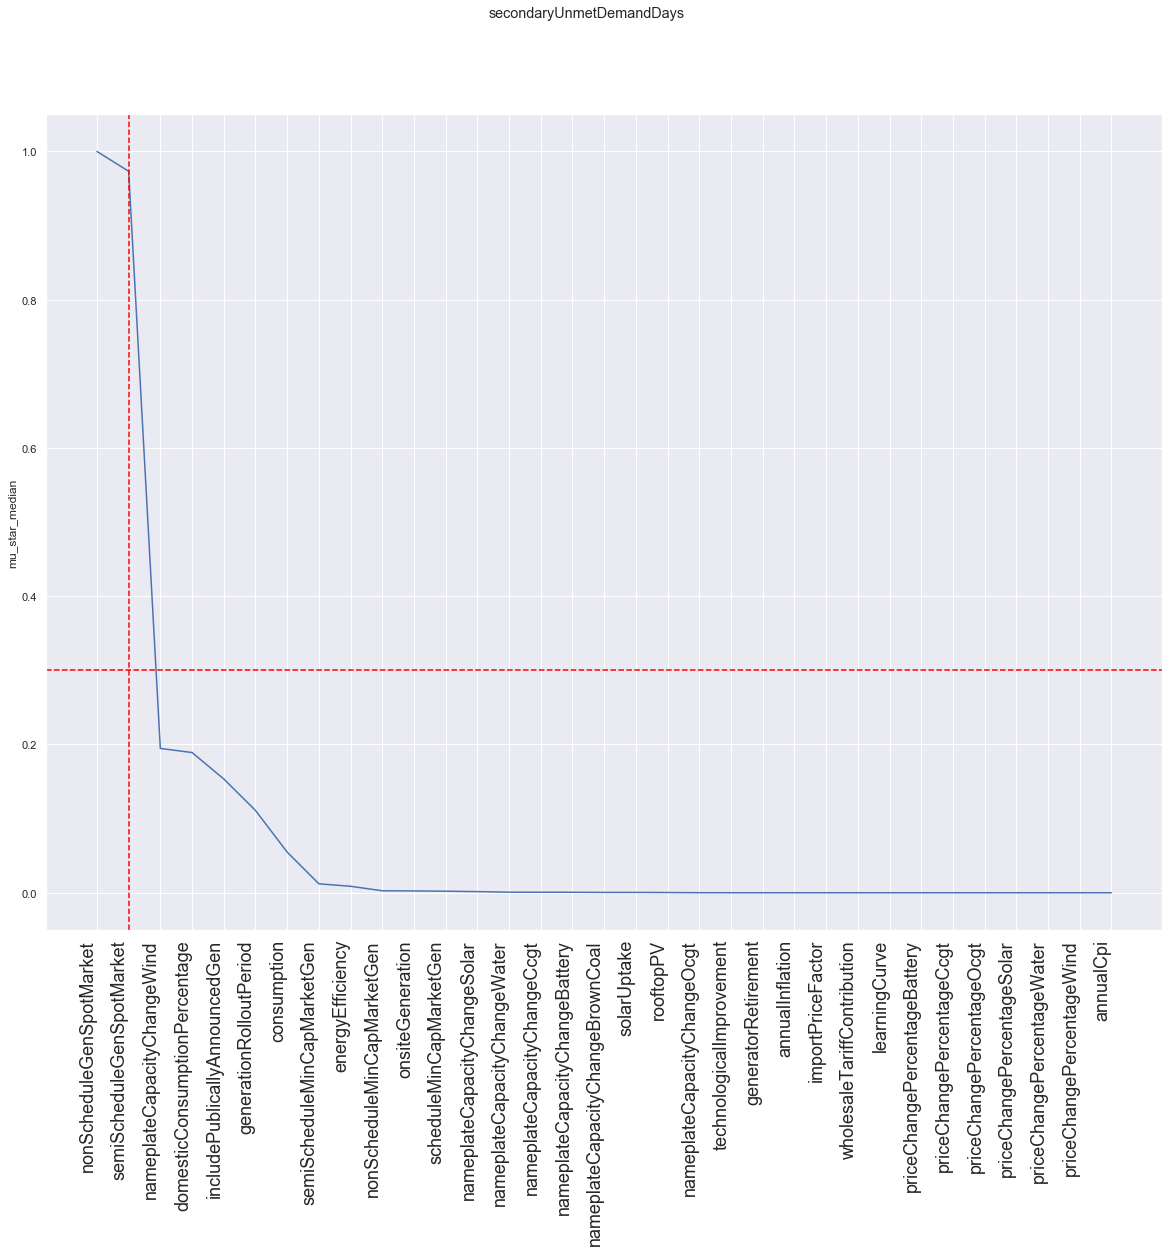

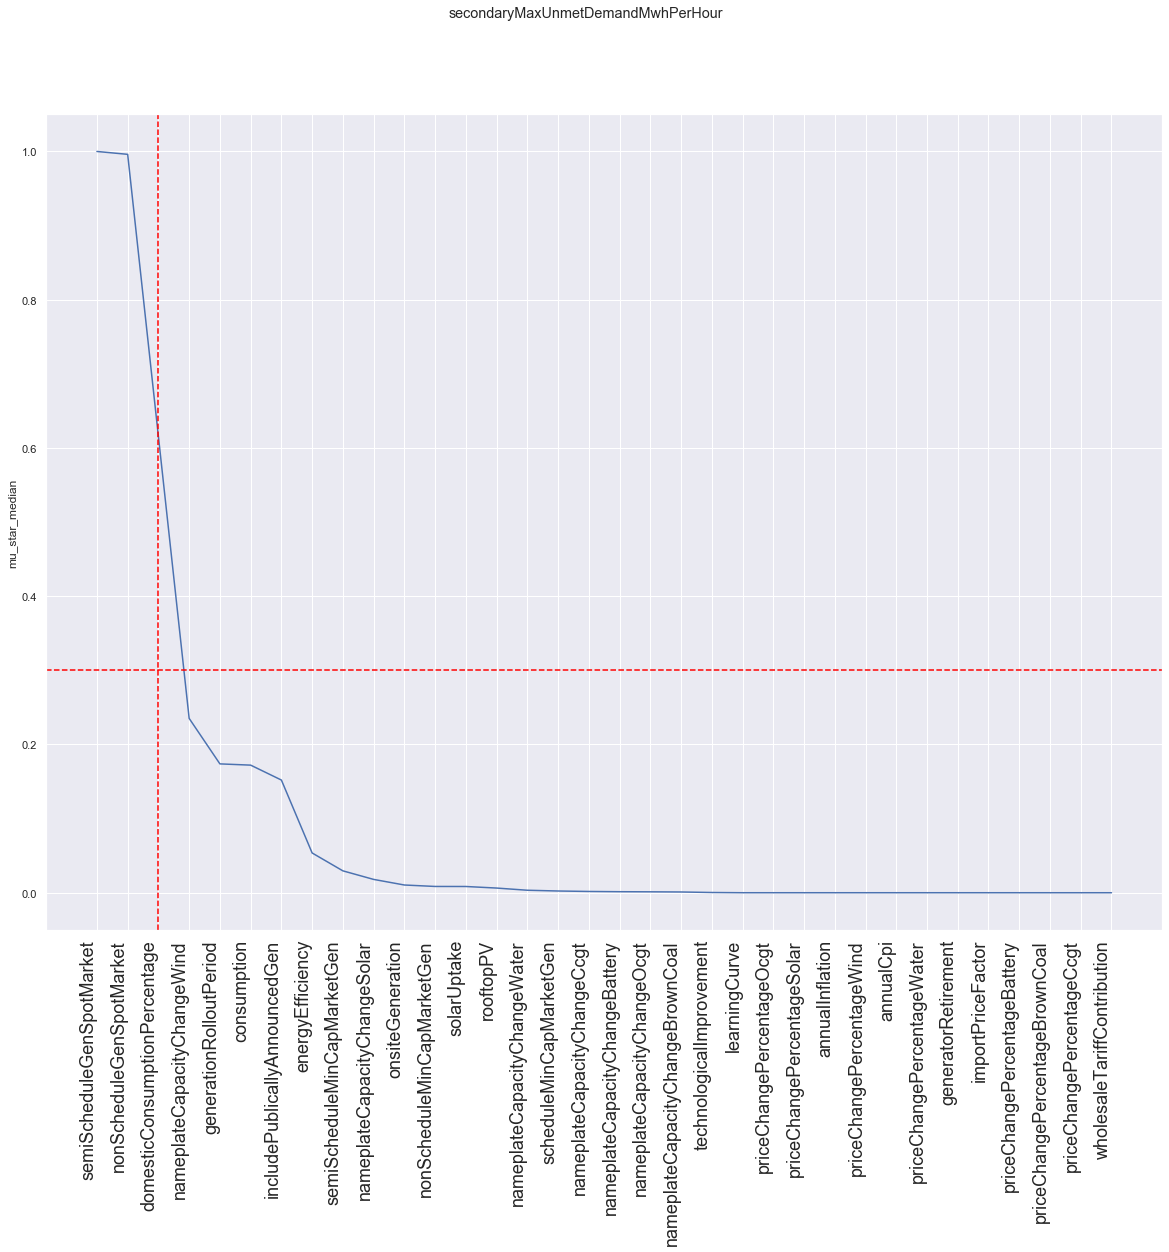

In [175]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 

#bound used to filter INPUTS
significance_bound = 0.3
significant_inputs_median = set()
significant_inputs_filter_median = {}

for ooi in outcomes_to_show:
    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_median_ooi[ooi] - mu_star_median_ooi[ooi].min())/(mu_star_median_ooi[ooi].max() - mu_star_median_ooi[ooi].min())
    normalized_sigma = (sigma_median_ooi[ooi] - sigma_median_ooi[ooi].min())/(sigma_median_ooi[ooi].max() - sigma_median_ooi[ooi].min())

    
    #create dataframe     
    df_max = pd.concat({'mu_star_median': normalized_mu_star,'sigma_median': normalized_sigma}, axis=1)

    
    #create figure
    f=plt.figure(figsize=(20,15))
    f.suptitle(ooi)
    
    #ScatterPlot        

    if includePlots:
        eet_plot = sns.lineplot(data=df_max['mu_star_median'].sort_values(ascending=False), markers=True)

        vertical_line = ''
        for item in eet_plot.get_xticklabels():
            item.set_rotation(90)
            item.set_horizontalalignment('right')
            item.set_fontsize(18)

        eet_plot.axhline(significance_bound,ls='--',color='red')
        
        if True in (normalized_mu_star > significance_bound).value_counts():
            vertical_line = (normalized_mu_star > significance_bound).value_counts()[True] - 1
            eet_plot.axvline( vertical_line ,ls='--',color='red')


        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', 'ranking_mu_star_median_%s'%(ooi)),dpi=300, bbox_inches='tight')


# print("ALL significant inputs (%d)"%len(significant_inputs_median))
# print(significant_inputs_median)

0 0
0 1
1 0
1 1


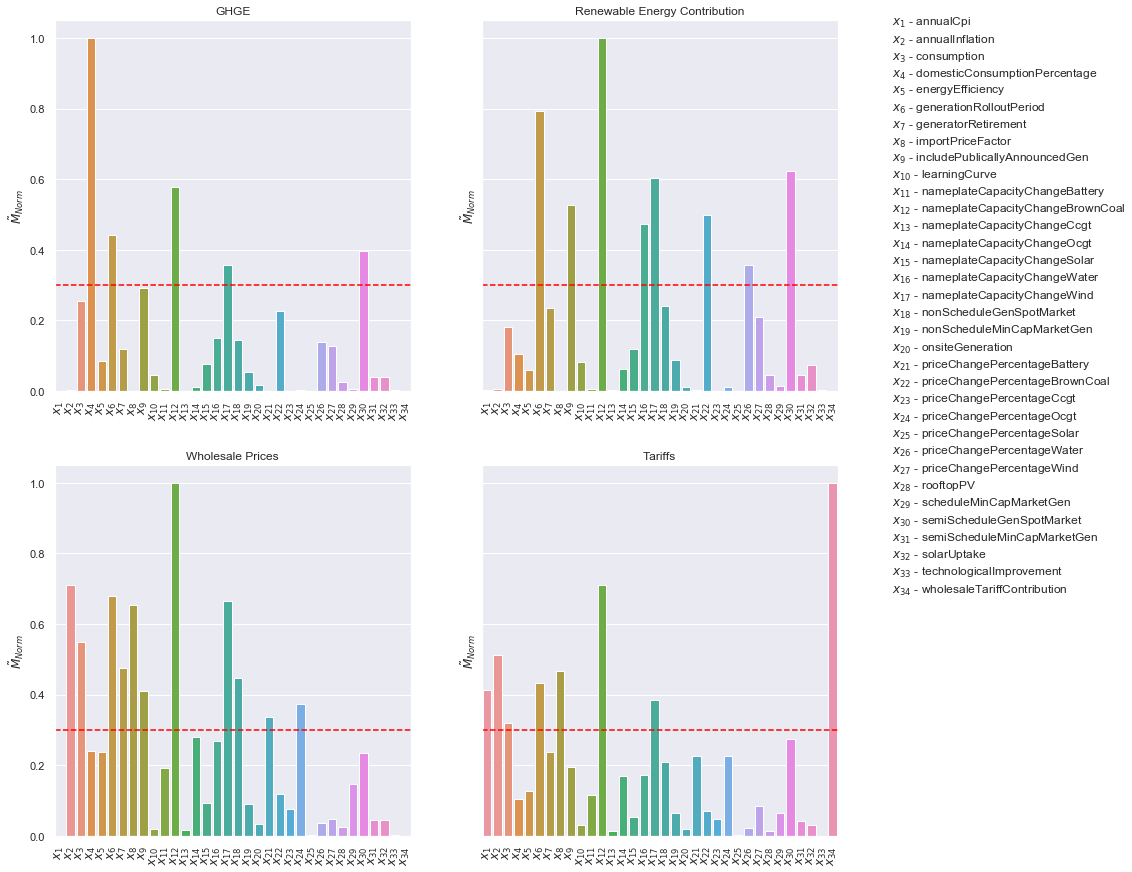

In [176]:
import seaborn as sns; sns.set()
#f = plt.figure(figsize=(20,30)) 

#bound used to filter INPUTS
significance_bound = 0.3
significant_inputs_median = set()
significant_inputs_filter_median = {}
outcomes_to_show = ['GHGYear', 'renewableContributionYear', 'wholesalePriceYear', 'tariffsYear']



#create multi-figure
fig, axes = plt.subplots(2, 2, figsize=(15, 15),sharey=True)
#fig.suptitle('Mu Star - Median')

# OOI

titles_ooi = {'GHGYear': 'GHGE', 'renewableContributionYear':'Renewable Energy Contribution', 
              'wholesalePriceYear': 'Wholesale Prices', 'tariffsYear':'Tariffs'  }

for idx, ooi in enumerate(outcomes_to_show):
    
    i = int(idx / 2)
    j = int(idx % 2)

    #Normalize values so all graphs are btw 0 and 1. Otherwise cannot use text coordinates below
    normalized_mu_star = (mu_star_median_ooi[ooi] - mu_star_median_ooi[ooi].min())/(mu_star_median_ooi[ooi].max() - mu_star_median_ooi[ooi].min())
    normalized_sigma = (sigma_median_ooi[ooi] - sigma_median_ooi[ooi].min())/(sigma_median_ooi[ooi].max() - sigma_median_ooi[ooi].min())

    
    #create dataframe     
    df_max = pd.concat({'M_norm': normalized_mu_star,'sigma_median': normalized_sigma}, axis=1)
    df_max['Input Factors'] = np.arange(len(df_max))+1

    if includePlots:
        print(i,j)
        eet_plot = sns.barplot(x='Input Factors',y='M_norm',data=df_max, ax=axes[i,j])
        #        eet_plot = sns.lineplot(data=df_max['mu_star_median'].sort_values(ascending=False), markers=True, ax=axes[i,j])

        axes[i,j].set_title(titles_ooi[ooi])

        
        eet_plot.set(xlabel='', ylabel='$\\tilde{M}_{Norm}$')
        vertical_line = ''
        for item in eet_plot.get_xticklabels():
            item.set_rotation(90)
            item.set_horizontalalignment('center')
            item.set_fontsize(12)
         
        #labels = df_max.sort_values('mu_star_median',ascending=False)['id'].values
        labels = df_max['Input Factors'].values
        
        labels = ['$x_{%d}$'%n for n in labels]

        axes[i,j].set_xticklabels(labels)

        eet_plot.axhline(significance_bound,ls='--',color='red')
        
#         if True in (normalized_mu_star > significance_bound).value_counts():
#             vertical_line = (normalized_mu_star > significance_bound).value_counts()[True] - 1
#             eet_plot.axvline( vertical_line ,ls='--',color='red')


if includePlots:
    #fig.legend(handles, labels, loc='upper center')
    # Create the legend
#     fig.legend([],     # The line objects
#                labels=df_max.index.values,   # The labels for each line
#                loc="center right",   # Position of legend
#                borderaxespad=0.1,    # Small spacing around legend box
#                title="Legend Title"  # Title for the legend
#                )
    x_legend = '\n'.join('$x_{%d}$ - %s'%(n,name) for n,name in zip(df_max['Input Factors'].values,df_max.index.values))

    t = axes[0,0].text(.9,.35,x_legend,transform=axes[0,0].figure.transFigure)
    fig.subplots_adjust(right=.85)
    

    plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', 'ranking_mu_star_median_subplots'),dpi=300, bbox_inches='tight')

## Boxplot

In [ ]:
# index = pd.to_datetime(time, format = '%Y')

# for ooi in outcomes_to_show:
#     data = outcomes[ooi][:, startYearShift:]
    
   
#     for u in uncertainties:
#         dfBoxPlot = pd.DataFrame(index = index, data = data.T,columns=[ experiments[u] ])
#         dfMeltdfBoxPlot = pd.melt(dfBoxPlot)
#         #dfMeltdfBoxPlot.rename(columns={"value":ooi})
    
#         ax = dfMeltdfBoxPlot.boxplot(by=u, meanline=True, showmeans=False, showcaps=True, 
#                         showbox=True, showfliers=False, return_type='axes', figsize=(15, 10))
        
        
#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_eet_boxplots_%s_%s'%(ooi,u)), 
#                      dpi=300, bbox_inches='tight')
        
       
#         plt.show()
#         plt.close()
